# Proyecto#2
### Entrenamiento Incremental en Modelos de Deep Learning y Machine Learning

#### Este trabajo práctico tiene como objetivo investigar la viabilidad del entrenamiento incremental en modelos de aprendizaje automático y profundo, utilizando como estudio de caso un dataset de transacciones de tarjeta de crédito clasificadas en normales y fraudulentas.

### - Parte 1: Entrenamiento Incremental

#### -> Implementación Práctica 

In [3]:
# Se importan librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
from scipy.stats import randint, uniform
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Cargar datos
df = pd.read_csv("fraud_feature.csv", header=0)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.0,0.0,True
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.0,0.0,True
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.0,0.0,True
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.0,0.0,True
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.0,0.0,True


#### Información del dataset y análisis exploratorio

In [3]:
df.shape

(1852394, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 
 18  unix_time             

In [5]:
print(df['category'].unique())

['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']


In [6]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,4.153689e+03,4.530560e+04,3.762028e+02,4.567241e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,3.909005e+03,3.586752e+04,7.253531e+02,4.575502e+00
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.000000e+00,1.020000e+00,0.000000e+00,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,1.344790e+03,1.734142e+04,9.020000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,3.071990e+03,3.743910e+04,7.589000e+01,3.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,5.738470e+03,6.472088e+04,4.259800e+02,7.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,4.326189e+04,2.190868e+05,1.204718e+04,4.800000e+01


In [7]:
df["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [8]:
df["merchant"].value_counts()

fraud_Kilback LLC                        6262
fraud_Cormier LLC                        5246
fraud_Schumm PLC                         5195
fraud_Kuhn LLC                           5031
fraud_Boyer PLC                          4999
                                         ... 
fraud_Douglas, DuBuque and McKenzie      1101
fraud_Treutel-King                       1098
fraud_Satterfield-Lowe                   1095
fraud_Hahn, Douglas and Schowalter       1091
fraud_Ritchie, Bradtke and Stiedemann    1090
Name: merchant, Length: 693, dtype: int64

Se realizan algunas modificaciones en el dataset, se ordena y se revisan datos nulos

In [9]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

In [10]:
df = df.sort_values(by='trans_date_trans_time')

In [11]:
df["cc_num"] = df["cc_num"].astype(str)

In [12]:
df["trans_num"].value_counts(dropna=False)

0b242abb623afc578575680df30655b9    1
ad44105b2defec28687e0c0c00db0dd2    1
fff81009b323191d0a427a2af21e5bc7    1
2341854d7594722011878c08ba3819dd    1
f7f00d638b16a8b1045d8a8978b607bd    1
                                   ..
74745c7e44a5172e919b2ea2538d0edb    1
71d44820f944faa2ed912043e859df48    1
986d5219c856c1ddcafe1a4ad35b844e    1
cf4fca8a9847c75240202201324dd34f    1
1765bb45b3aa3224b4cdcb6e7a96cee3    1
Name: trans_num, Length: 1852394, dtype: int64

In [13]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.0,0.0,True
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.0,0.0,True
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.0,0.0,True
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.0,0.0,True
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.0,0.0,True


In [14]:
print(df.isnull().sum())
df.drop_duplicates(inplace=True)

trans_date_trans_time           0
cc_num                          0
merchant                        0
category                        0
amt                             0
first                           0
last                            0
gender                          0
street                          0
city                            0
state                           0
zip                             0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
trans_num                       0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2242906758.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


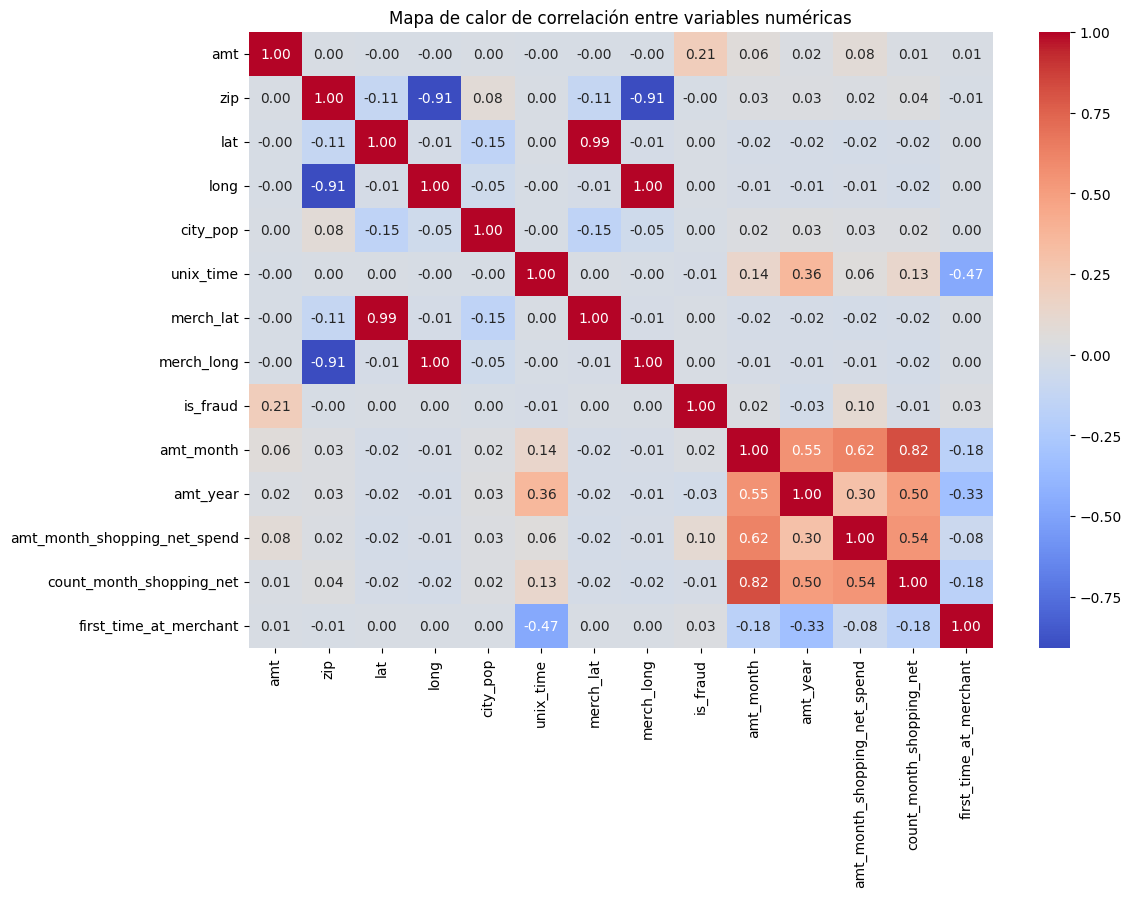

In [15]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Gráfico de mapa de calor de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlación entre variables numéricas')
plt.show()

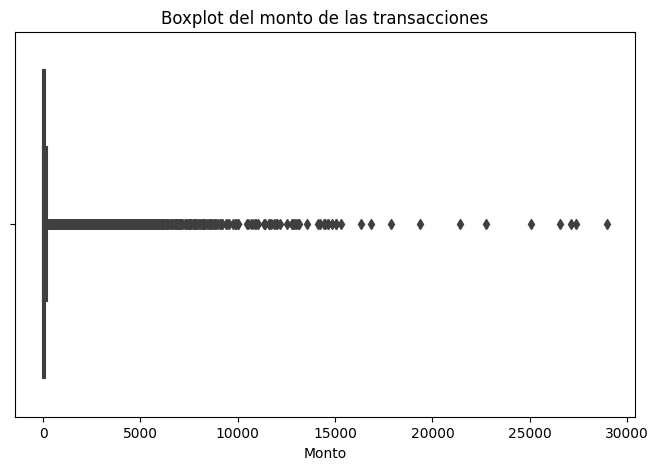

In [16]:
# Boxplot del monto de las transacciones para detectar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x='amt', data=df)
plt.title('Boxplot del monto de las transacciones')
plt.xlabel('Monto')
plt.show()

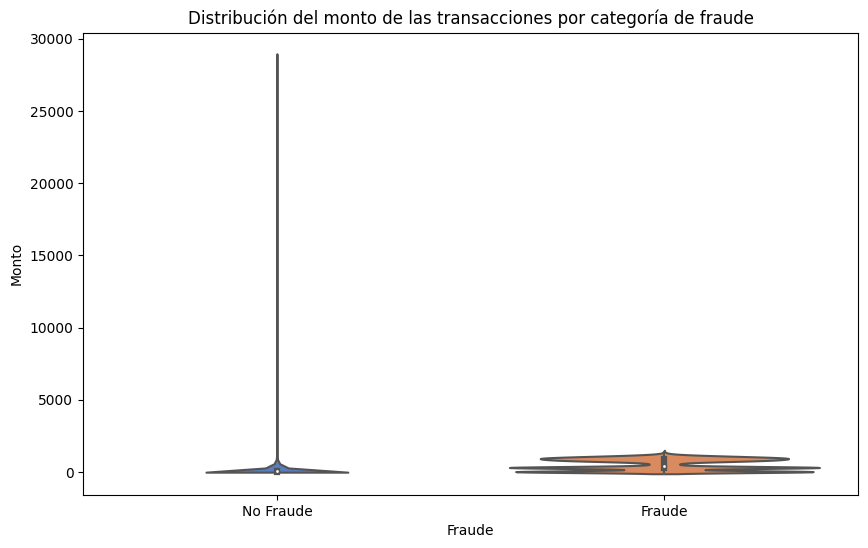

In [17]:
# Gráfico de violín del monto de las transacciones por categoría de fraude
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df, palette='muted')
plt.title('Distribución del monto de las transacciones por categoría de fraude')
plt.xlabel('Fraude')
plt.ylabel('Monto')
plt.xticks(ticks=[0, 1], labels=['No Fraude', 'Fraude'])
plt.show()

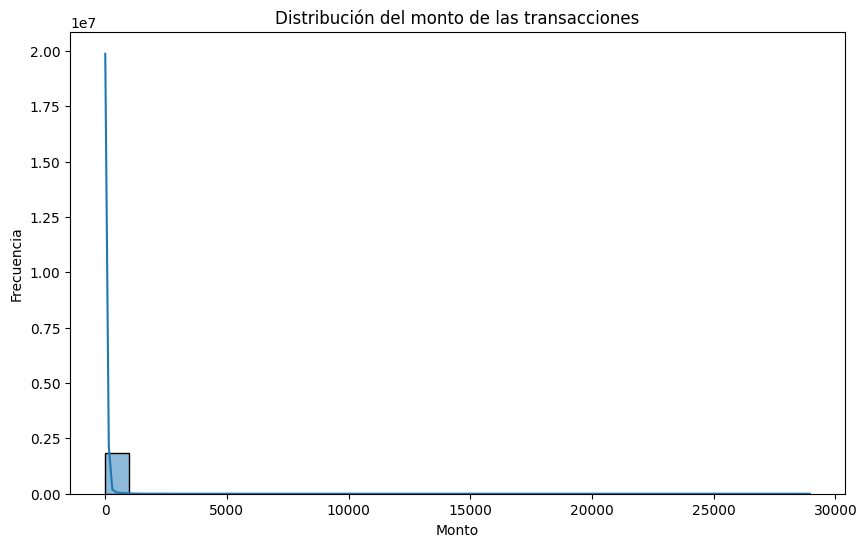

In [18]:
# Histograma de la distribución de la cantidad de transacciones
plt.figure(figsize=(10, 6))
sns.histplot(df['amt'], bins=30, kde=True)
plt.title('Distribución del monto de las transacciones')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.show()

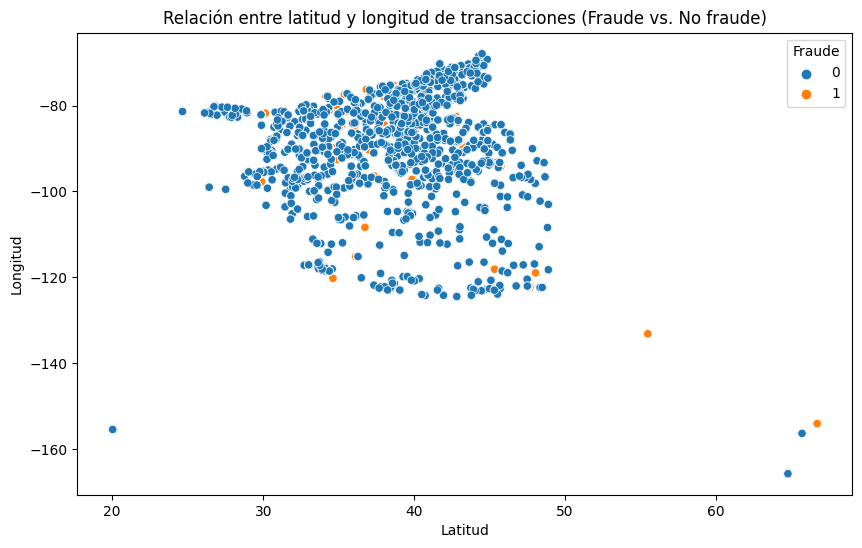

In [19]:
# Gráfico de dispersión para la relación entre latitud y longitud de la transacción
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lat', y='long', data=df, hue='is_fraud')
plt.title('Relación entre latitud y longitud de transacciones (Fraude vs. No fraude)')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.legend(title='Fraude')
plt.show()

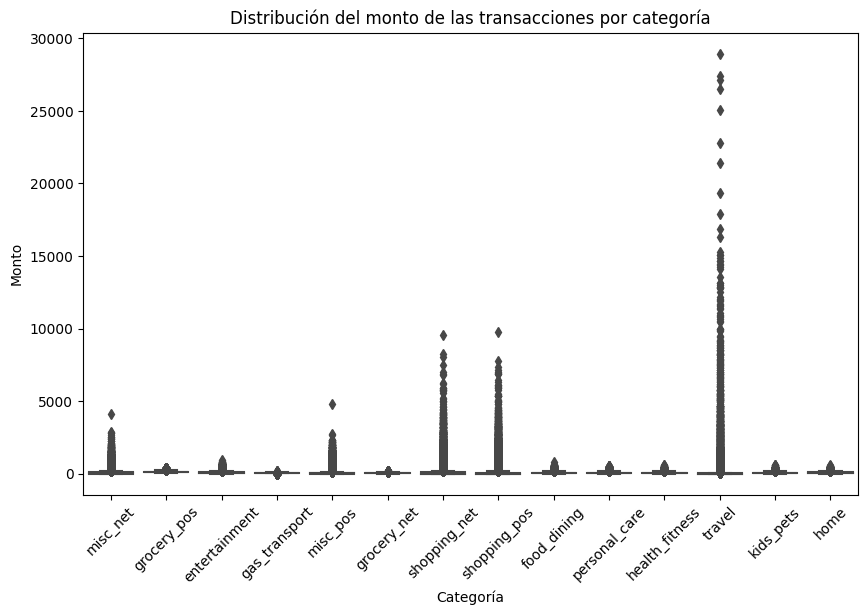

In [20]:
# Boxplot del monto de las transacciones por categoría
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='amt', data=df)
plt.title('Distribución del monto de las transacciones por categoría')
plt.xlabel('Categoría')
plt.ylabel('Monto')
plt.xticks(rotation=45)
plt.show()

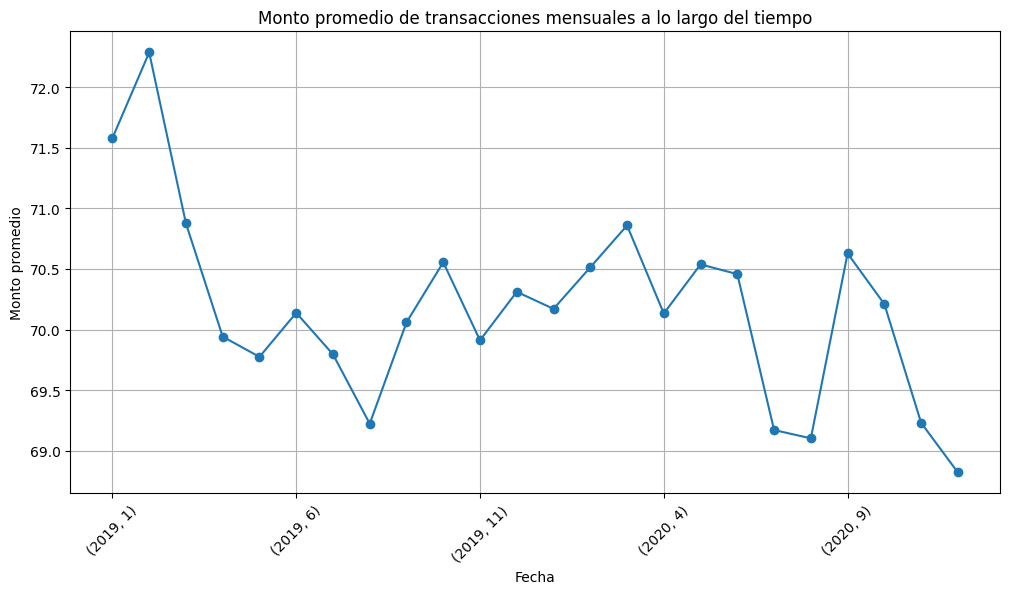

In [21]:
# Convertir 'trans_date_trans_time' a formato de fecha y hora
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Gráfico de línea del monto promedio de transacciones mensuales a lo largo del tiempo
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

plt.figure(figsize=(12, 6))
df.groupby(['year', 'month'])['amt'].mean().plot(marker='o')
plt.title('Monto promedio de transacciones mensuales a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Monto promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

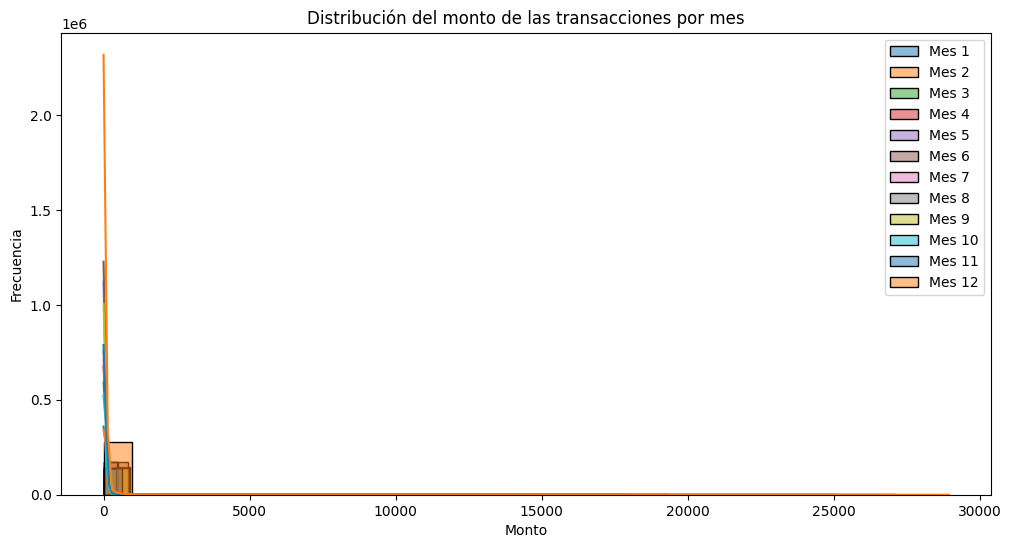

In [22]:
# Histograma del monto de las transacciones por mes
plt.figure(figsize=(12, 6))
for month in range(1, 13):
    df_month = df[df['month'] == month]
    sns.histplot(df_month['amt'], bins=30, kde=True, label=f'Mes {month}', alpha=0.5)
plt.title('Distribución del monto de las transacciones por mes')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

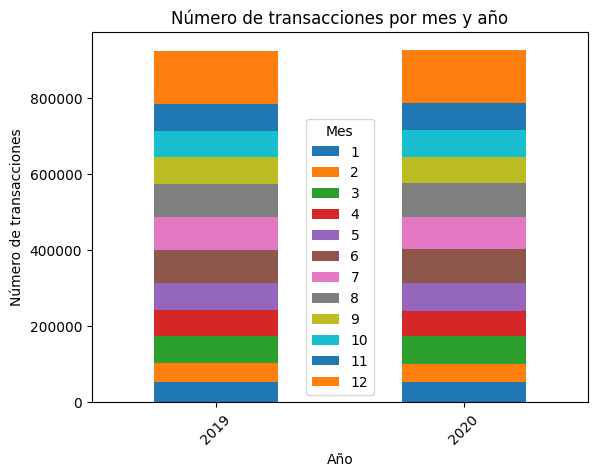

In [23]:
# Gráfico de barras del número de transacciones por mes y año
plt.figure(figsize=(12, 6))
transacciones_por_mes_y_anio = df.groupby(['year', 'month']).size().unstack()
transacciones_por_mes_y_anio.plot(kind='bar', stacked=True)
plt.title('Número de transacciones por mes y año')
plt.xlabel('Año')
plt.ylabel('Número de transacciones')
plt.xticks(rotation=45)
plt.legend(title='Mes')
plt.show()

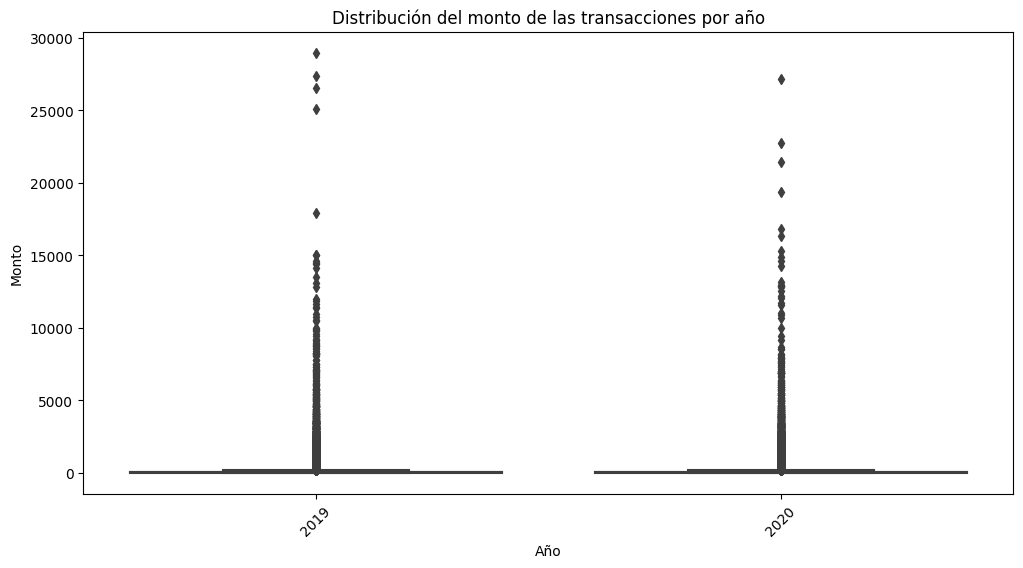

In [24]:
# Boxplot del monto de las transacciones por año
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='amt', data=df)
plt.title('Distribución del monto de las transacciones por año')
plt.xlabel('Año')
plt.ylabel('Monto')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

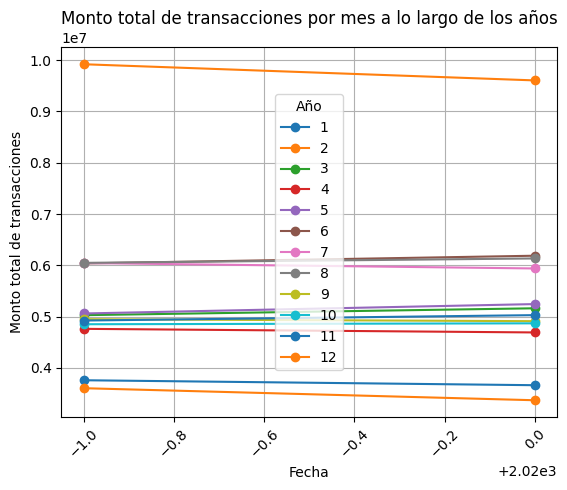

In [25]:
# Gráfico de líneas del monto total de transacciones por mes a lo largo de los años
monto_total_por_mes_y_anio = df.groupby(['year', 'month'])['amt'].sum().unstack()
plt.figure(figsize=(12, 6))
monto_total_por_mes_y_anio.plot(marker='o')
plt.title('Monto total de transacciones por mes a lo largo de los años')
plt.xlabel('Fecha')
plt.ylabel('Monto total de transacciones')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Año')
plt.show()

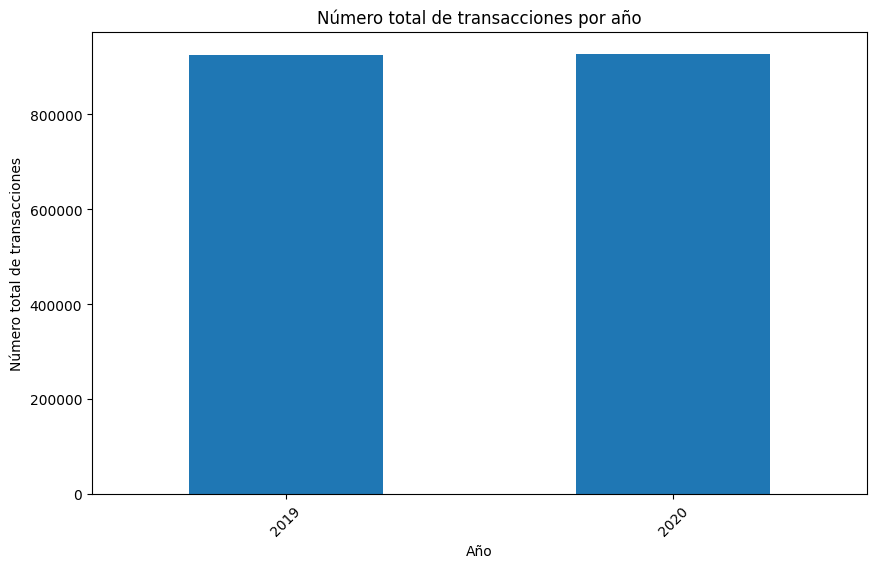

In [26]:
# Gráfico de barras del número total de transacciones por año
transacciones_totales_por_anio = df.groupby('year').size()
plt.figure(figsize=(10, 6))
transacciones_totales_por_anio.plot(kind='bar')
plt.title('Número total de transacciones por año')
plt.xlabel('Año')
plt.ylabel('Número total de transacciones')
plt.xticks(rotation=45)
plt.show()

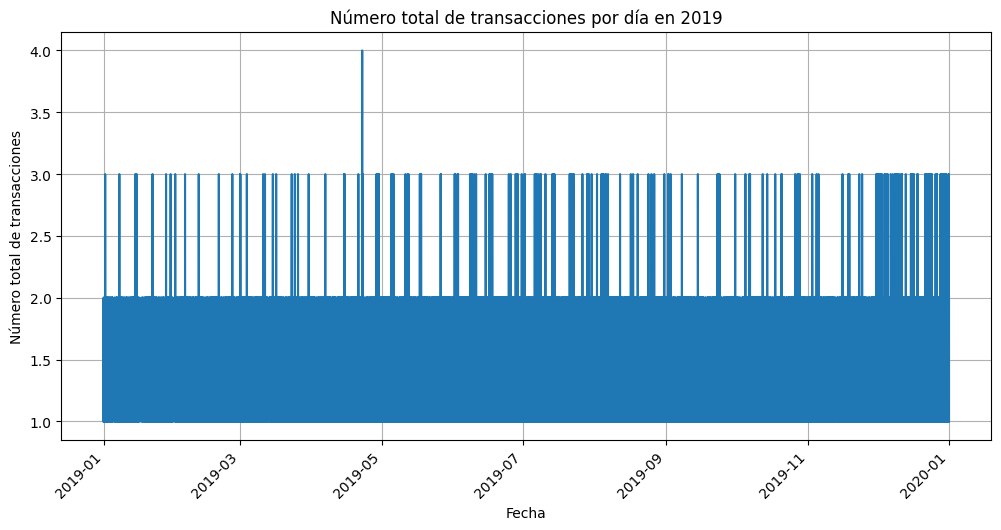

In [27]:
# Gráfico de línea del número total de transacciones por día durante un período de tiempo específico
# Por ejemplo, el año 2019
transacciones_por_dia_2019 = df[df['year'] == 2019].groupby('trans_date_trans_time').size()
plt.figure(figsize=(12, 6))
transacciones_por_dia_2019.plot()
plt.title('Número total de transacciones por día en 2019')
plt.xlabel('Fecha')
plt.ylabel('Número total de transacciones')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

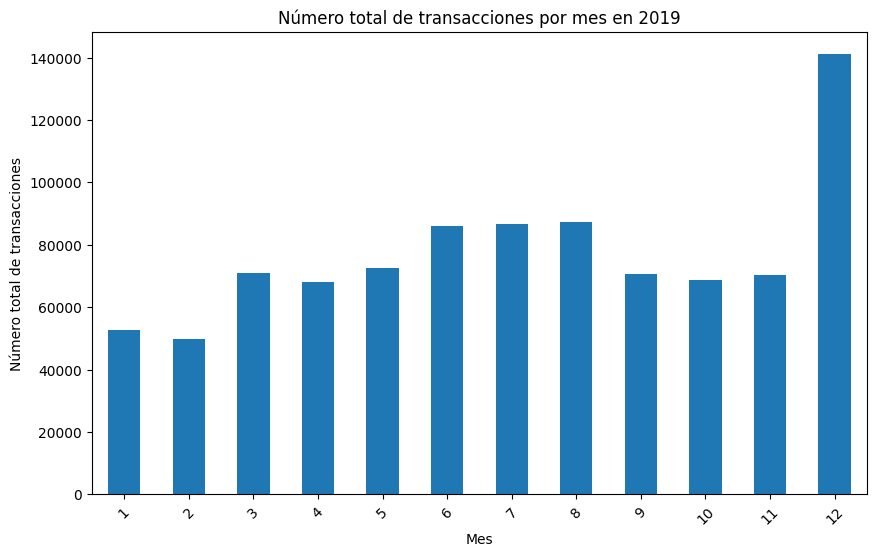

In [28]:
# Gráfico de barras del número total de transacciones por mes para un año específico
transacciones_por_mes_2019 = df[df['year'] == 2019].groupby('month').size()
plt.figure(figsize=(10, 6))
transacciones_por_mes_2019.plot(kind='bar')
plt.title('Número total de transacciones por mes en 2019')
plt.xlabel('Mes')
plt.ylabel('Número total de transacciones')
plt.xticks(rotation=45)
plt.show()

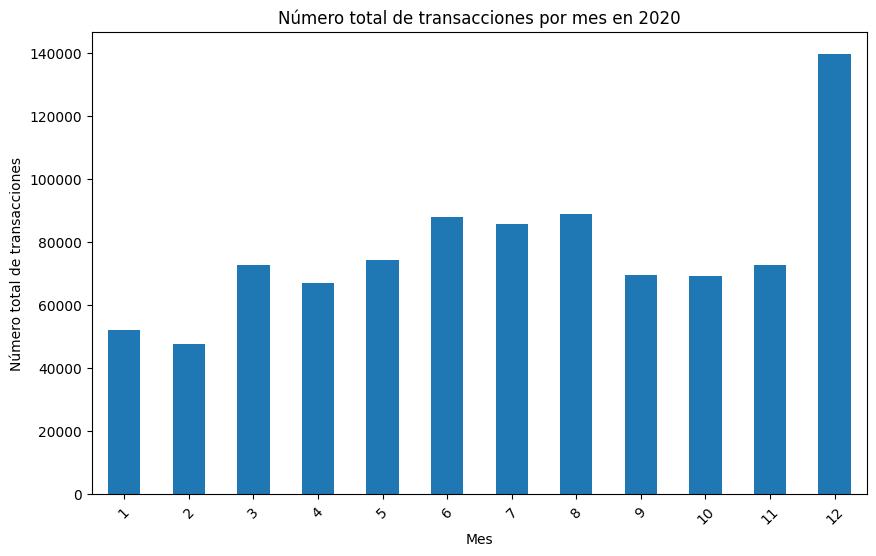

In [29]:
# Gráfico de barras del número total de transacciones por mes para un año específico
transacciones_por_mes_2019 = df[df['year'] == 2020].groupby('month').size()
plt.figure(figsize=(10, 6))
transacciones_por_mes_2019.plot(kind='bar')
plt.title('Número total de transacciones por mes en 2020')
plt.xlabel('Mes')
plt.ylabel('Número total de transacciones')
plt.xticks(rotation=45)
plt.show()

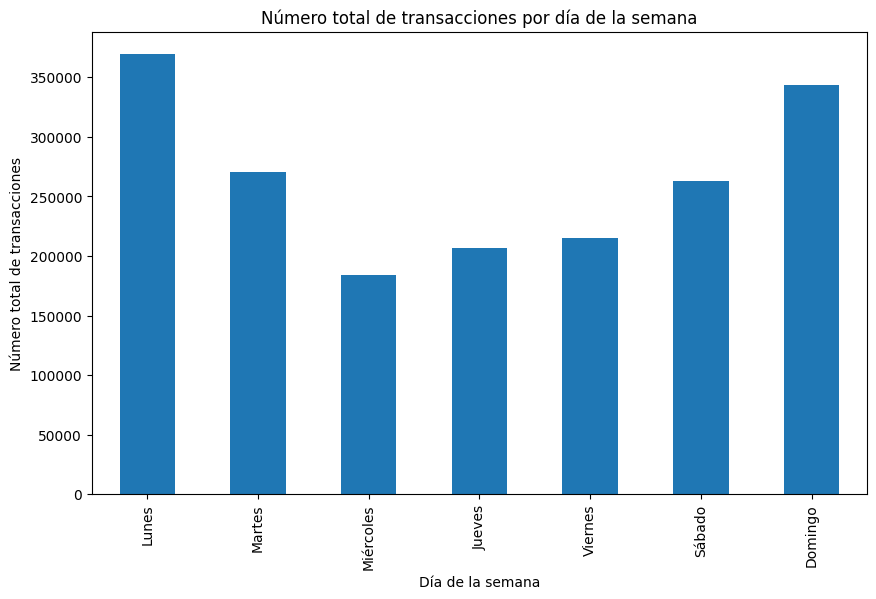

In [30]:
# Gráfico de barras del número total de transacciones por día de la semana
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
transacciones_por_dia_semana = df.groupby('day_of_week').size()
plt.figure(figsize=(10, 6))
transacciones_por_dia_semana.plot(kind='bar')
plt.title('Número total de transacciones por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Número total de transacciones')
plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

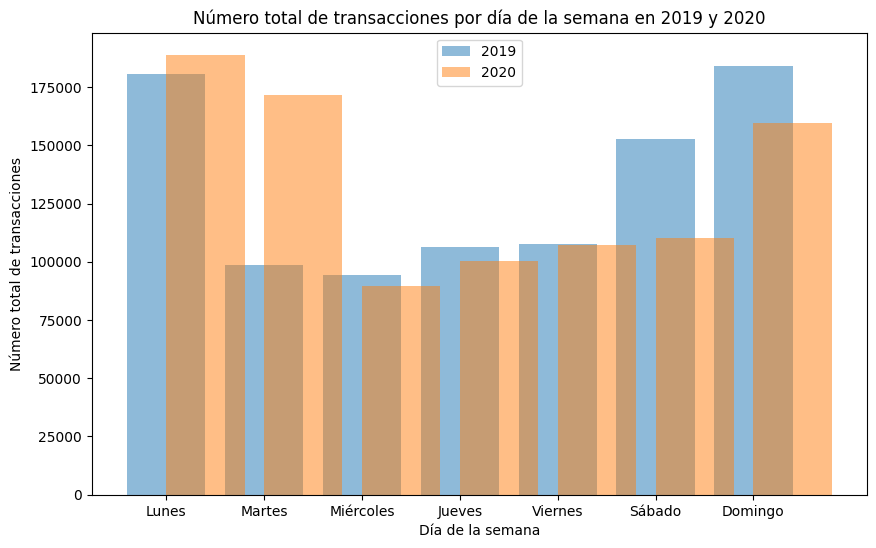

Día con más transacciones en 2019: Domingo
Día con más transacciones en 2020: Lunes


In [31]:
# Filtrar los datos por año 2019 y 2020
df_2019 = df[df['year'] == 2019]
df_2020 = df[df['year'] == 2020]

# Agrupar los datos por día de la semana y contar el número de transacciones para cada año
transacciones_por_dia_semana_2019 = df_2019.groupby('day_of_week').size()
transacciones_por_dia_semana_2020 = df_2020.groupby('day_of_week').size()

# Encontrar el día con más transacciones para cada año
dia_mas_transacciones_2019 = transacciones_por_dia_semana_2019.idxmax()
dia_mas_transacciones_2020 = transacciones_por_dia_semana_2020.idxmax()

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(transacciones_por_dia_semana_2019.index, transacciones_por_dia_semana_2019, label='2019', alpha=0.5)
plt.bar(transacciones_por_dia_semana_2020.index + 0.4, transacciones_por_dia_semana_2020, label='2020', alpha=0.5)
plt.title('Número total de transacciones por día de la semana en 2019 y 2020')
plt.xlabel('Día de la semana')
plt.ylabel('Número total de transacciones')
plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.legend()
plt.show()

# Imprimir el día con más transacciones para cada año
print(f"Día con más transacciones en 2019: {['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'][dia_mas_transacciones_2019]}")
print(f"Día con más transacciones en 2020: {['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'][dia_mas_transacciones_2020]}")


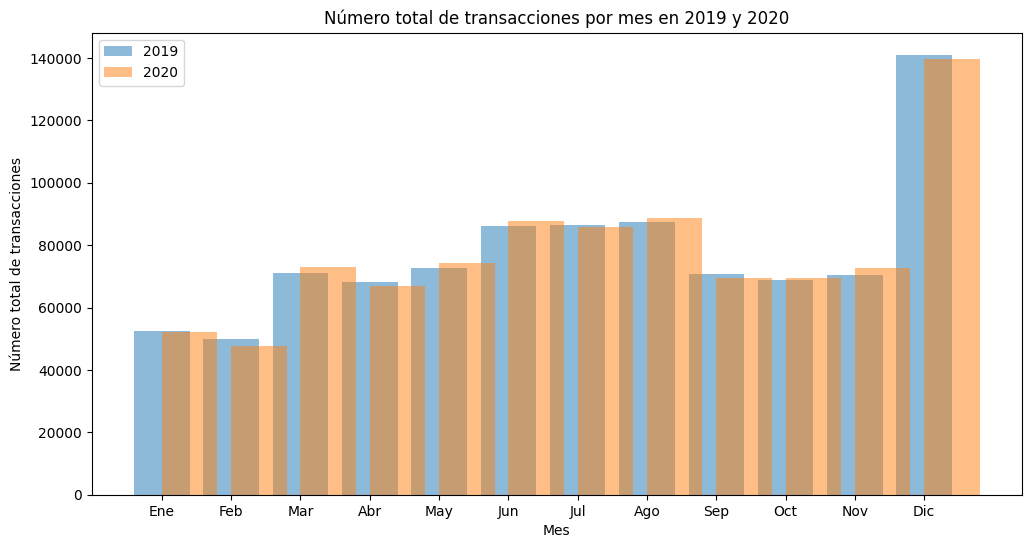

Mes con más transacciones en 2019: Dic
Mes con más transacciones en 2020: Dic


In [32]:
# Agrupar los datos por mes y contar el número de transacciones para cada año
transacciones_por_mes_2019 = df_2019.groupby('month').size()
transacciones_por_mes_2020 = df_2020.groupby('month').size()

# Encontrar el mes con más transacciones para cada año
mes_mas_transacciones_2019 = transacciones_por_mes_2019.idxmax()
mes_mas_transacciones_2020 = transacciones_por_mes_2020.idxmax()

# Graficar el número total de transacciones por mes en 2019 y 2020
plt.figure(figsize=(12, 6))
plt.bar(transacciones_por_mes_2019.index, transacciones_por_mes_2019, label='2019', alpha=0.5)
plt.bar(transacciones_por_mes_2020.index + 0.4, transacciones_por_mes_2020, label='2020', alpha=0.5)
plt.title('Número total de transacciones por mes en 2019 y 2020')
plt.xlabel('Mes')
plt.ylabel('Número total de transacciones')
plt.xticks(ticks=range(1, 13), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend()
plt.show()

# Imprimir el mes con más transacciones para cada año
print(f"Mes con más transacciones en 2019: {['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'][mes_mas_transacciones_2019-1]}")
print(f"Mes con más transacciones en 2020: {['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'][mes_mas_transacciones_2020-1]}")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2569743039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['quarter'] = df['trans_date_trans_time'].dt.quarter
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2569743039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['quarter'] = df['trans_date_trans_time'].dt.quarter


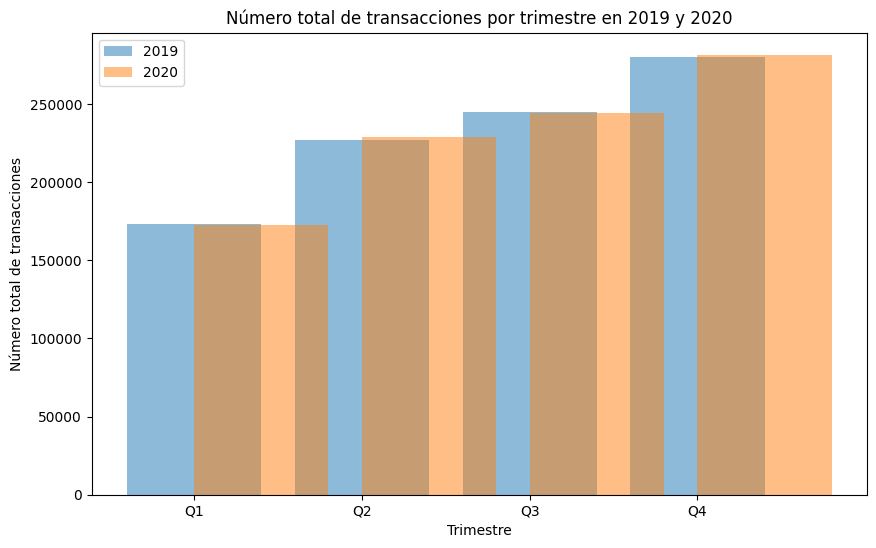

Trimestre con más transacciones en 2019: Q4
Trimestre con más transacciones en 2020: Q4


In [33]:
df_2019['quarter'] = df['trans_date_trans_time'].dt.quarter
df_2020['quarter'] = df['trans_date_trans_time'].dt.quarter

# Agrupar los datos por trimestre y contar el número de transacciones para cada año
transacciones_por_trimestre_2019 = df_2019.groupby('quarter').size()
transacciones_por_trimestre_2020 = df_2020.groupby('quarter').size()

# Encontrar el trimestre con más transacciones para cada año
trimestre_mas_transacciones_2019 = transacciones_por_trimestre_2019.idxmax()
trimestre_mas_transacciones_2020 = transacciones_por_trimestre_2020.idxmax()

# Graficar el número total de transacciones por trimestre en 2019 y 2020
plt.figure(figsize=(10, 6))
plt.bar(transacciones_por_trimestre_2019.index, transacciones_por_trimestre_2019, label='2019', alpha=0.5)
plt.bar(transacciones_por_trimestre_2020.index + 0.4, transacciones_por_trimestre_2020, label='2020', alpha=0.5)
plt.title('Número total de transacciones por trimestre en 2019 y 2020')
plt.xlabel('Trimestre')
plt.ylabel('Número total de transacciones')
plt.xticks(ticks=[1, 2, 3, 4], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.show()

# Imprimir el trimestre con más transacciones para cada año
print(f"Trimestre con más transacciones en 2019: Q{trimestre_mas_transacciones_2019}")
print(f"Trimestre con más transacciones en 2020: Q{trimestre_mas_transacciones_2020}")

In [34]:
# Calcular el semestre a partir de los datos de fecha
df_2019['semester'] = (df['month'] - 1) // 6 + 1
df_2020['semester'] = (df['month'] - 1) // 6 + 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2925884062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['semester'] = (df['month'] - 1) // 6 + 1
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2925884062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['semester'] = (df['month'] - 1) // 6 + 1


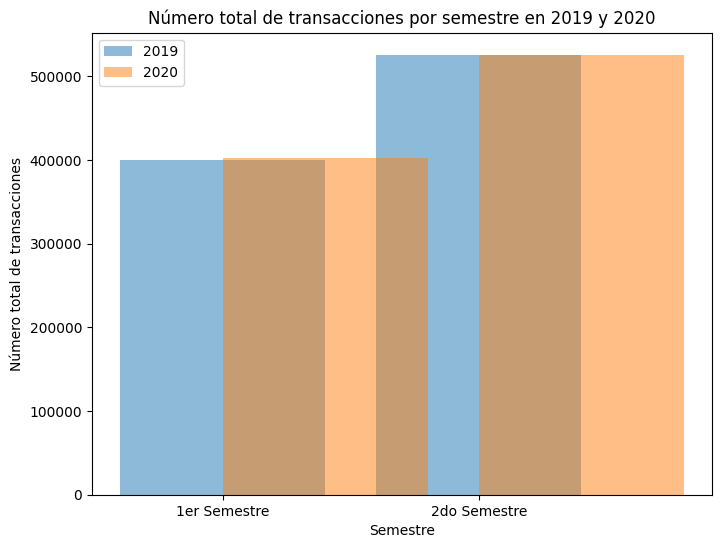

Semestre con más transacciones en 2019: 2do Semestre
Semestre con más transacciones en 2020: 2do Semestre


In [35]:
# Agrupar los datos por semestre y contar el número de transacciones para cada año
transacciones_por_semestre_2019 = df_2019.groupby('semester').size()
transacciones_por_semestre_2020 = df_2020.groupby('semester').size()

# Encontrar el semestre con más transacciones para cada año
semestre_mas_transacciones_2019 = transacciones_por_semestre_2019.idxmax()
semestre_mas_transacciones_2020 = transacciones_por_semestre_2020.idxmax()

# Graficar el número total de transacciones por semestre en 2019 y 2020
plt.figure(figsize=(8, 6))
plt.bar(transacciones_por_semestre_2019.index, transacciones_por_semestre_2019, label='2019', alpha=0.5)
plt.bar(transacciones_por_semestre_2020.index + 0.4, transacciones_por_semestre_2020, label='2020', alpha=0.5)
plt.title('Número total de transacciones por semestre en 2019 y 2020')
plt.xlabel('Semestre')
plt.ylabel('Número total de transacciones')
plt.xticks(ticks=[1, 2], labels=['1er Semestre', '2do Semestre'])
plt.legend()
plt.show()

# Imprimir el semestre con más transacciones para cada año
print(f"Semestre con más transacciones en 2019: {['1er Semestre', '2do Semestre'][semestre_mas_transacciones_2019 - 1]}")
print(f"Semestre con más transacciones en 2020: {['1er Semestre', '2do Semestre'][semestre_mas_transacciones_2020 - 1]}")


## Preprocesamiento e incremento de data
#### (Estas primeras 5 funciones son las que fueron proporcionadas para fines de ejemplo)

### Amount month by card

In [36]:
def get_amount_month_by_card(group):
    """
    Calculate the cumulative sum of transaction amounts per month for each credit card.

    Parameters:
    - group (DataFrame): A group of transactions for a specific credit card.

    Returns:
    DataFrame: The input DataFrame with an additional column 'amt_month' representing
    the cumulative sum of transaction amounts per month for each credit card.
    """
    group['amt_month'] = group.groupby([group['trans_date_trans_time'].dt.year, group['trans_date_trans_time'].dt.month])['amt'].cumsum()
    return group

df = df.groupby('cc_num').apply(get_amount_month_by_card).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\4125840303.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(get_amount_month_by_card).reset_index(drop=True)


### Amount anual by card

In [37]:
def get_amount_anual_by_card(group):
    """
    Calculate the cumulative sum of transaction amounts per year for each credit card.

    Parameters:
    - group (DataFrame): A group of transactions for a specific credit card.

    Returns:
    DataFrame: The input DataFrame with an additional column 'amt_year' representing
    the cumulative sum of transaction amounts per year for each credit card.
    """
    group['amt_year'] = group.groupby(group['trans_date_trans_time'].dt.year)['amt'].cumsum()
    return group

df = df.groupby('cc_num').apply(get_amount_anual_by_card).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\2618860821.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(get_amount_anual_by_card).reset_index(drop=True)


### Amount month by card in category == shooping_net

In [38]:
year_month = ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
 '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
 '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
 '2020-10', '2020-11', '2020-12']

def get_amount_month_by_card_shopping_net_spend(group):
    """
    Calculate the cumulative monthly spending on shopping_net category for each credit card.

    Parameters:
    - group (DataFrame): A group of transactions for a specific credit card.

    Returns:
    DataFrame: The input DataFrame with an additional column 'amt_month_shopping_net_spend' representing
    the cumulative monthly spending on shopping_net category for each credit card.
    """
    
    subset_shopping_net = group[group['category'] == 'shopping_net']
    group['amt_month_shopping_net_spend'] = subset_shopping_net.groupby(group['trans_date_trans_time'].dt.to_period('M'))['amt'].cumsum()

    group['y_month'] = group['trans_date_trans_time'].dt.to_period('M')
    for y_month in year_month:
        group.loc[group['y_month'] == y_month, 'amt_month_shopping_net_spend'] = group.loc[group['y_month'] == y_month, 'amt_month_shopping_net_spend'].fillna(method='ffill')
        group.loc[group['y_month'] == y_month, 'amt_month_shopping_net_spend'] = group.loc[group['y_month'] == y_month, 'amt_month_shopping_net_spend'].fillna(0)
        
    return group.drop('y_month', axis=1)


df = df.groupby('cc_num').apply(get_amount_month_by_card_shopping_net_spend).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\1663278142.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(get_amount_month_by_card_shopping_net_spend).reset_index(drop=True)


### Count month by card in category == shooping_net

In [39]:
def get_count_trx_month_by_card_shopping_net(group):
    """
    Calculate the cumulative count of transactions in the shopping_net category per month for each credit card.

    Parameters:
    - group (DataFrame): A group of transactions for a specific credit card.

    Returns:
    DataFrame: The input DataFrame with an additional column 'count_month_shopping_net' representing
    the cumulative count of transactions in the shopping_net category per month for each credit card.
    """
    
    subset_shopping_net = group[group['category'] == 'shopping_net']
    group['count_month_shopping_net'] = subset_shopping_net.groupby(group['trans_date_trans_time'].dt.to_period('M')).cumcount() + 1

    group['y_month'] = group['trans_date_trans_time'].dt.to_period('M')
    for y_month in year_month:
        group.loc[group['y_month'] == y_month, 'count_month_shopping_net'] = group.loc[group['y_month'] == y_month, 'count_month_shopping_net'].fillna(method='ffill')
        group.loc[group['y_month'] == y_month, 'count_month_shopping_net'] = group.loc[group['y_month'] == y_month, 'count_month_shopping_net'].fillna(0)
        
    return group.drop('y_month', axis=1)

df = df.groupby('cc_num').apply(get_count_trx_month_by_card_shopping_net).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\3502608662.py:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(get_count_trx_month_by_card_shopping_net).reset_index(drop=True)


### Condition fist time at merchant

In [40]:
def is_first_time_transaction_at_merchant(group):
    """
    Determine if a transaction is the first time at a merchant for each credit card.

    Parameters:
    - group (DataFrame): A group of transactions for a specific credit card.

    Returns:
    DataFrame: The input DataFrame with an additional column 'first_time_at_merchant' indicating
    whether each transaction is the first time at the merchant for each credit card.
    """
    group['first_time_at_merchant'] = ~group.duplicated(subset=['merchant', 'cc_num'])
    return group

df = df.groupby('cc_num').apply(is_first_time_transaction_at_merchant).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\1539611835.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(is_first_time_transaction_at_merchant).reset_index(drop=True)


### Amount and count month by card in category == x

In [41]:
categories = ['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
              'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
              'food_dining', 'personal_care', 'health_fitness', 'travel',
              'kids_pets', 'home']

def get_amount_month_by_card(group, category):
    subset_category = group[group['category'] == category]
    group['amt_month_{}_spend'.format(category)] = subset_category.groupby(group['trans_date_trans_time'].dt.to_period('M'))['amt'].cumsum()

    group['y_month'] = group['trans_date_trans_time'].dt.to_period('M')
    for y_month in year_month:
        group.loc[group['y_month'] == y_month, 'amt_month_{}_spend'.format(category)] = group.loc[group['y_month'] == y_month, 'amt_month_{}_spend'.format(category)].fillna(method='ffill')
        group.loc[group['y_month'] == y_month, 'amt_month_{}_spend'.format(category)] = group.loc[group['y_month'] == y_month, 'amt_month_{}_spend'.format(category)].fillna(0)
        
    return group.drop('y_month', axis=1)

def get_count_trx_month_by_card(group, category):
    subset_category = group[group['category'] == category]
    group['count_month_{}_trx'.format(category)] = subset_category.groupby(group['trans_date_trans_time'].dt.to_period('M')).cumcount() + 1

    group['y_month'] = group['trans_date_trans_time'].dt.to_period('M')
    for y_month in year_month:
        group.loc[group['y_month'] == y_month, 'count_month_{}_trx'.format(category)] = group.loc[group['y_month'] == y_month, 'count_month_{}_trx'.format(category)].fillna(method='ffill')
        group.loc[group['y_month'] == y_month, 'count_month_{}_trx'.format(category)] = group.loc[group['y_month'] == y_month, 'count_month_{}_trx'.format(category)].fillna(0)
        
    return group.drop('y_month', axis=1)

for category in categories:
    df = df.groupby('cc_num').apply(lambda x: get_amount_month_by_card(x, category)).reset_index(drop=True)
    df = df.groupby('cc_num').apply(lambda x: get_count_trx_month_by_card(x, category)).reset_index(drop=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\293918680.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('cc_num').apply(lambda x: get_amount_month_by_card(x, category)).reset_index(drop=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\293918680.py:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 



In [42]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df = df.drop('day_of_week', axis=1)
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] < 6)).astype(int)
df = df.drop('hour_of_day', axis=1)

df = df.sort_values(by='trans_date_trans_time')

df["customer_num_transactions_1_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["customer_num_transactions_7_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["customer_num_transactions_30_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count()
)[
    "amt"
]

df["customer_avg_amount_1_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean()
)["amt"]
df["customer_avg_amount_7_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean()
)["amt"]
df["customer_avg_amount_30_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean()
)["amt"]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\596995961.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\596995961.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14

In [43]:
df.head(300)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,amt_month_home_spend,count_month_home_trx,is_weekend,is_night,customer_num_transactions_1_day,customer_num_transactions_7_day,customer_num_transactions_30_day,customer_avg_amount_1_day,customer_avg_amount_7_day,customer_avg_amount_30_day
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0.0,0.0,0,1,1.0,1.0,1.0,4.97,4.97,4.97
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0.0,0.0,0,1,1.0,1.0,1.0,107.23,107.23,107.23
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0.0,0.0,0,1,1.0,1.0,1.0,220.11,220.11,220.11
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0.0,0.0,0,1,1.0,1.0,1.0,45.00,45.00,45.00
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0.0,0.0,0,1,1.0,1.0,1.0,41.96,41.96,41.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2019-01-01 03:50:59,3506042666828517,fraud_Ledner-Pfannerstill,gas_transport,54.04,Christine,Burns,F,343 Hannah Parkway,Comfort,...,0.0,0.0,0,1,1.0,1.0,1.0,54.04,54.04,54.04
296,2019-01-01 03:51:28,571844099986,fraud_Heathcote LLC,shopping_net,909.66,Susan,Mills,F,005 Cody Estates,Louisville,...,0.0,0.0,0,1,1.0,1.0,1.0,909.66,909.66,909.66
297,2019-01-01 03:52:20,4045036286570100739,"fraud_Rowe, Batz and Goodwin",grocery_pos,103.31,Bianca,Scott,F,9588 Cox Rapid Apt. 257,Atglen,...,0.0,0.0,0,1,1.0,1.0,1.0,103.31,103.31,103.31
298,2019-01-01 03:54:07,4400011257587661852,fraud_VonRueden Group,grocery_net,105.38,Marissa,Powell,F,474 Allen Haven,North Loup,...,0.0,0.0,0,1,1.0,1.0,1.0,105.38,105.38,105.38


In [44]:
df['dob'] = pd.to_datetime(df['dob'])

# Calculate transaction hour and day
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day

In [45]:
df.head(300)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_weekend,is_night,customer_num_transactions_1_day,customer_num_transactions_7_day,customer_num_transactions_30_day,customer_avg_amount_1_day,customer_avg_amount_7_day,customer_avg_amount_30_day,trans_hour,trans_day
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,1,1.0,1.0,1.0,4.97,4.97,4.97,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,1,1.0,1.0,1.0,107.23,107.23,107.23,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,1,1.0,1.0,1.0,220.11,220.11,220.11,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,1,1.0,1.0,1.0,45.00,45.00,45.00,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,1,1.0,1.0,1.0,41.96,41.96,41.96,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2019-01-01 03:50:59,3506042666828517,fraud_Ledner-Pfannerstill,gas_transport,54.04,Christine,Burns,F,343 Hannah Parkway,Comfort,...,0,1,1.0,1.0,1.0,54.04,54.04,54.04,3,1
296,2019-01-01 03:51:28,571844099986,fraud_Heathcote LLC,shopping_net,909.66,Susan,Mills,F,005 Cody Estates,Louisville,...,0,1,1.0,1.0,1.0,909.66,909.66,909.66,3,1
297,2019-01-01 03:52:20,4045036286570100739,"fraud_Rowe, Batz and Goodwin",grocery_pos,103.31,Bianca,Scott,F,9588 Cox Rapid Apt. 257,Atglen,...,0,1,1.0,1.0,1.0,103.31,103.31,103.31,3,1
298,2019-01-01 03:54:07,4400011257587661852,fraud_VonRueden Group,grocery_net,105.38,Marissa,Powell,F,474 Allen Haven,North Loup,...,0,1,1.0,1.0,1.0,105.38,105.38,105.38,3,1


In [49]:
df["terminal_num_transactions_1_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count()
)[
    "amt"
]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\3559403009.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(


In [50]:
df["terminal_num_transactions_7_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count()
)[
    "amt"
]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\3427885194.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(


In [51]:
df["terminal_num_transactions_30_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count()
)[
    "amt"
]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14536\1035899830.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(


In [47]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_weekend,is_night,customer_num_transactions_1_day,customer_num_transactions_7_day,customer_num_transactions_30_day,customer_avg_amount_1_day,customer_avg_amount_7_day,customer_avg_amount_30_day,trans_hour,trans_day
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,1,1.0,1.0,1.0,4.97,4.97,4.97,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,1,1.0,1.0,1.0,107.23,107.23,107.23,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,1,1.0,1.0,1.0,220.11,220.11,220.11,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,1,1.0,1.0,1.0,45.00,45.00,45.00,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,1,1.0,1.0,1.0,41.96,41.96,41.96,0,1


In [ ]:
pd.concat(
    [
        df[df["is_fraud"] == 1].sample(5, random_state=0),
        df[df["is_fraud"] == 0].sample(5, random_state=0),
    ]
).sample(10, random_state=0)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,customer_num_transactions_30_day,customer_avg_amount_1_day,customer_avg_amount_7_day,customer_avg_amount_30_day,trans_hour,trans_day,age,terminal_num_transactions_1_day,terminal_num_transactions_7_day,terminal_num_transactions_30_day
1578941,2020-10-04 22:36:23,30510856607165,fraud_Terry-Huel,shopping_net,941.23,Frederick,Robinson,M,1125 Ray Track,Livonia,...,33.0,554.184000,310.936000,147.728788,22,4,59.0,1.0,1.0,1.0
351968,2019-06-14 11:54:45,180036456789979,fraud_Nader-Heller,misc_net,8.10,Mackenzie,Salazar,F,982 Melissa Lock,Bagley,...,167.0,44.864000,56.107857,75.332994,11,14,49.0,1.0,1.0,1.0
1326571,2020-06-30 23:16:40,571844099986,"fraud_Haley, Jewess and Bechtelar",shopping_pos,917.97,Susan,Mills,F,005 Cody Estates,Louisville,...,121.0,777.228571,271.883929,109.643306,23,30,72.0,1.0,1.0,1.0
706851,2019-10-28 14:32:13,30197398657930,fraud_Auer LLC,personal_care,87.63,April,Johnson,F,9727 Deleon Mountain,Creedmoor,...,104.0,70.222222,86.081852,77.388942,14,28,36.0,1.0,1.0,1.0
765084,2019-11-23 23:02:36,347612609554823,fraud_Balistreri-Nader,misc_pos,8.40,Robert,James,M,18316 Cannon Place,Newport,...,38.0,462.596667,262.648571,83.996053,23,23,28.0,1.0,1.0,1.0
1248660,2020-06-03 23:10:22,180094419304907,fraud_Schuppe LLC,entertainment,377.05,Sharon,Smith,F,17666 David Valleys,Sun City,...,171.0,189.440000,81.276098,84.837076,23,3,51.0,1.0,1.0,1.0
367841,2019-06-19 17:00:51,6011348830550197,"fraud_Watsica, Haag and Considine",shopping_pos,1.13,Samuel,Johnston,M,16285 Jessica Lights,Birmingham,...,165.0,24.010000,66.951489,66.510788,17,19,43.0,1.0,1.0,1.0
1249951,2020-06-04 15:27:30,4502539526809429801,fraud_Denesik and Sons,shopping_pos,961.63,Stephanie,Cummings,F,1025 Robin Square,Ash Flat,...,86.0,404.955000,172.152857,95.360233,15,4,97.0,1.0,1.0,1.0
114068,2019-03-05 16:30:49,4306630852918,fraud_Fisher-Schowalter,shopping_net,914.49,Maureen,Garza,F,169 Edward Inlet,Saint Louis,...,39.0,625.252500,250.153077,116.247436,16,5,64.0,1.0,1.0,1.0
1346821,2020-07-08 00:51:30,4129767952109660,fraud_Block-Parisian,misc_net,7.00,Cheryl,Ballard,F,248 James Squares Apt. 838,Halstad,...,68.0,43.060000,54.510500,57.049706,0,8,51.0,1.0,1.0,1.0


Se guarda el dataset en otro csv para evitar repetir todo el proceso de Ingeniería de variables

In [ ]:
df.to_csv("Caracteristicas.csv", index=False)

### Ajustes en el dataset, división de datos y creación de modelos

In [8]:
df = pd.read_csv("Caracteristicas.csv")

In [3]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_month', 'amt_year',
       'amt_month_shopping_net_spend', 'count_month_shopping_net',
       'first_time_at_merchant', 'month', 'year', 'amt_month_misc_net_spend',
       'count_month_misc_net_trx', 'amt_month_grocery_pos_spend',
       'count_month_grocery_pos_trx', 'amt_month_entertainment_spend',
       'count_month_entertainment_trx', 'amt_month_gas_transport_spend',
       'count_month_gas_transport_trx', 'amt_month_misc_pos_spend',
       'count_month_misc_pos_trx', 'amt_month_grocery_net_spend',
       'count_month_grocery_net_trx', 'count_month_shopping_net_trx',
       'amt_month_shopping_pos_spend', 'count_month_shopping_pos_trx',
       'amt_month_food_dining_spend', 'count_month_food_dining_trx',
       'amt_mon

# Modelos

Se realiza la preparación del dataset y se inicia con el primer modelo

In [9]:
# Eliminar columnas innecesarias
columns_to_drop = ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time']
df = df.drop(columns=columns_to_drop)

# Separar características (X) y etiquetas (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Dividir datos en Train y Test basado en el año
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=df['year'])

# Equilibrar el dataset solo en el conjunto de entrenamiento
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Normalizar datos numéricos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Modelo Red Neuronal Artificial (ANN)

In [10]:
# Definir y entrenar el modelo ANN
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_scaled, y_train_balanced, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo ANN en Test
y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy_ann = accuracy_score(y_test, y_pred_ann)
cm_ann = confusion_matrix(y_test, y_pred_ann)
report_ann = classification_report(y_test, y_pred_ann)

Epoch 1/10
55278/55278 [==============================] - 147s 3ms/step - loss: 0.0459 - accuracy: 0.9839 - val_loss: 0.0365 - val_accuracy: 0.9870
Epoch 2/10
55278/55278 [==============================] - 147s 3ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0330 - val_accuracy: 0.9885
Epoch 3/10
55278/55278 [==============================] - 153s 3ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0256 - val_accuracy: 0.9909
Epoch 4/10
55278/55278 [==============================] - 189s 3ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0308 - val_accuracy: 0.9891
Epoch 5/10
55278/55278 [==============================] - 226s 4ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0187 - val_accuracy: 0.9936
Epoch 6/10
55278/55278 [==============================] - 175s 3ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.0159 - val_accuracy: 0.9944
Epoch 7/10
55278/55278 [==============================] - 196s 4ms/step - loss: 0.0103 - accuracy: 0.9968 - val_

In [11]:
print("Modelo ANN:")
print("Accuracy:", accuracy_ann)
print("\nMatriz de Confusión:")
print(cm_ann)
print("\nReporte de Clasificación:")
print(report_ann)

Modelo ANN:
Accuracy: 0.9960065212873064

Matriz de Confusión:
[[734608   2580]
 [   379   3391]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    737188
           1       0.57      0.90      0.70      3770

    accuracy                           1.00    740958
   macro avg       0.78      0.95      0.85    740958
weighted avg       1.00      1.00      1.00    740958



23155/23155 [==============================] - 38s 2ms/step


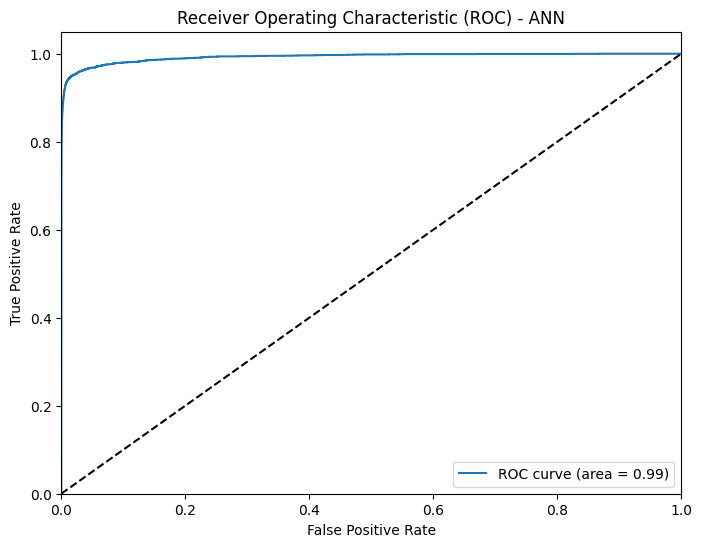

In [12]:
# Obtener las probabilidades de clase para Test
y_pred_proba_ann = ann_model.predict(X_test_scaled)

# Calcular el FPR y TPR para diferentes umbrales
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_proba_ann)

# Calcular el área bajo la curva ROC para el modelo ANN
roc_auc_ann = roc_auc_score(y_test, y_pred_proba_ann)

# Graficar la curva ROC para el modelo ANN
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label='ROC curve (area = %0.2f)' % roc_auc_ann)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - ANN')
plt.legend(loc="lower right")
plt.show()

## Modelo LightGBM

In [13]:
# Definir y entrenar el modelo LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train_balanced)

# Predecir las probabilidades de clase para Test
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas de evaluación para LightGBM
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

print("Modelo LightGBM:")
print("Accuracy:", roc_auc_lgb)

# Predecir las clases para Test
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Calcular la matriz de confusión para el modelo LightGBM
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# Visualizar la matriz de confusión
print("\nMatriz de Confusión")
print(cm_lgb)

# Classification Report
report_lgb = classification_report(y_test, y_pred_lgb)
print("\nReporte de Clasificación:")
print(report_lgb)

Modelo LightGBM:
Accuracy: 0.9944380037791899

Matriz de Confusión
[[734456   2732]
 [   451   3319]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    737188
           1       0.55      0.88      0.68      3770

    accuracy                           1.00    740958
   macro avg       0.77      0.94      0.84    740958
weighted avg       1.00      1.00      1.00    740958



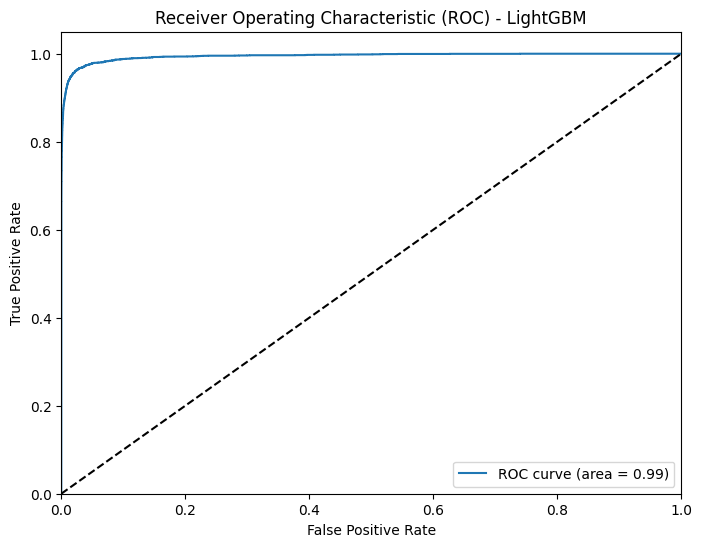

In [14]:
# Graficar la curva ROC para LightGBM
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label='ROC curve (area = %0.2f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc="lower right")
plt.show()

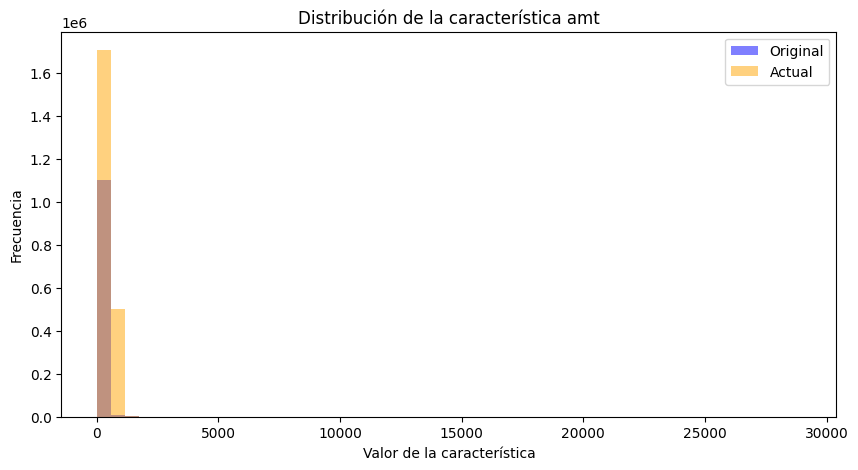

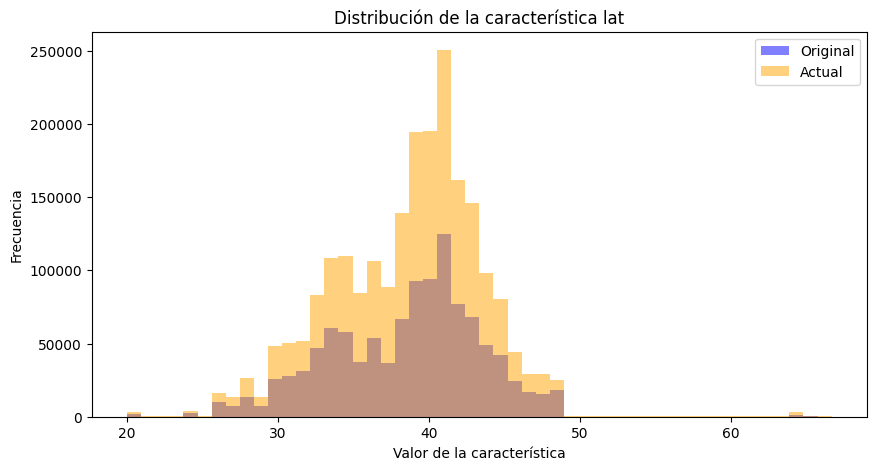

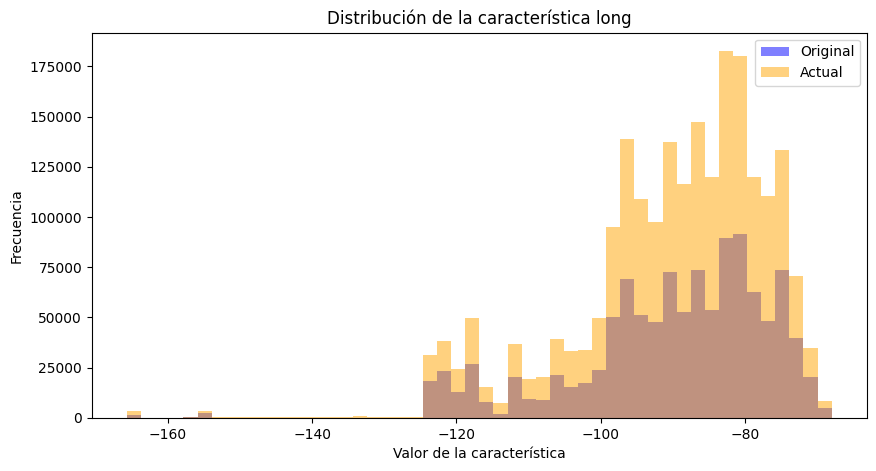

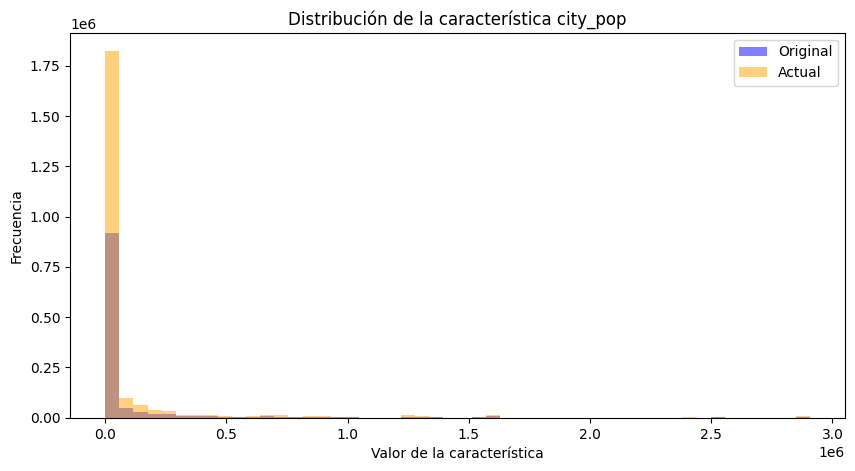

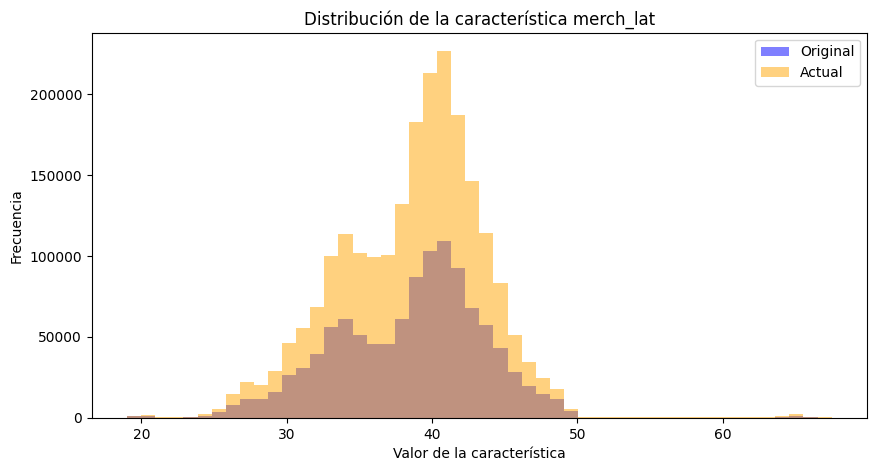

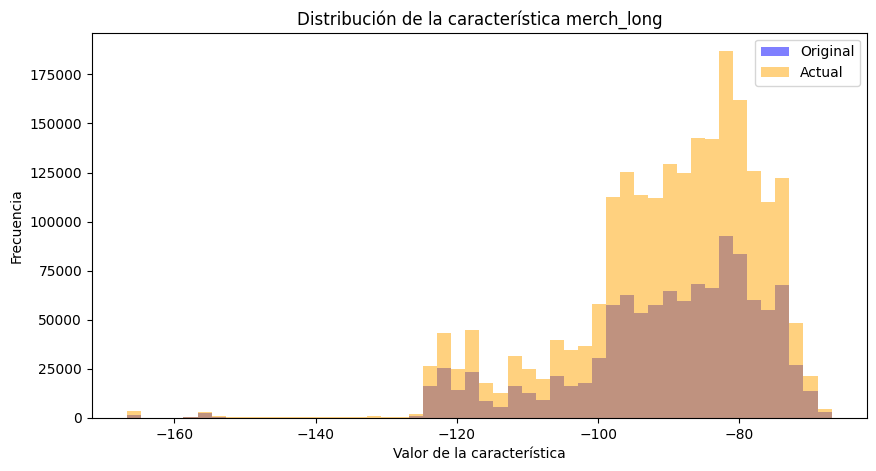

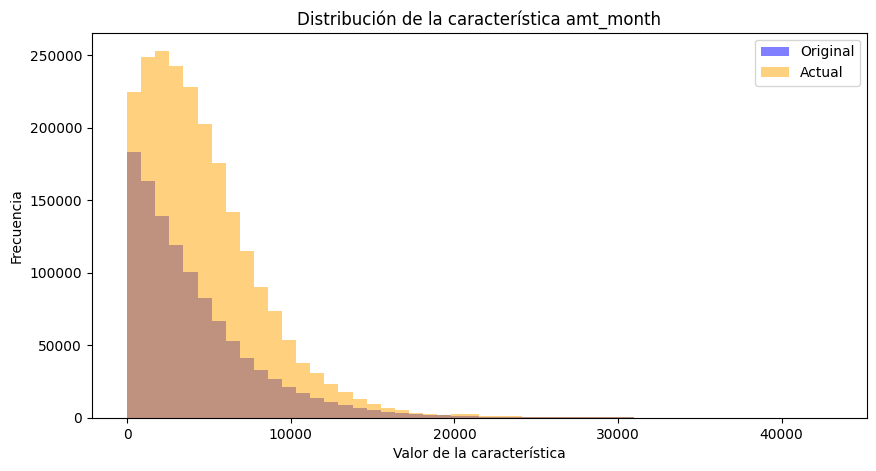

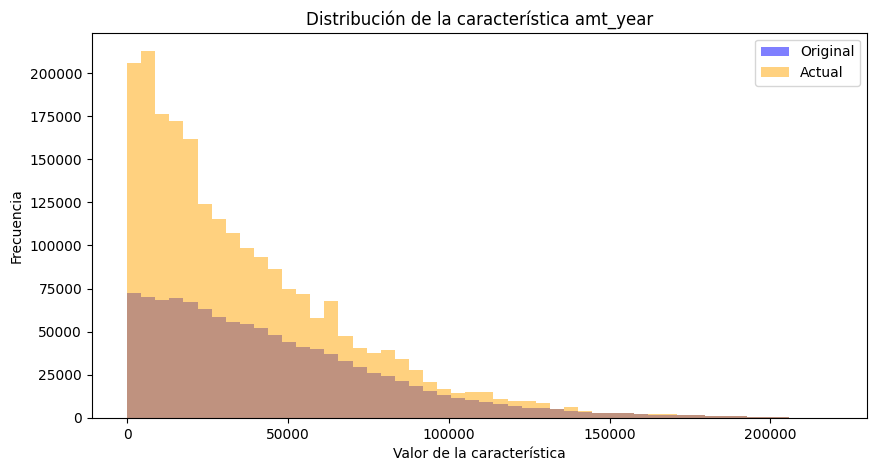

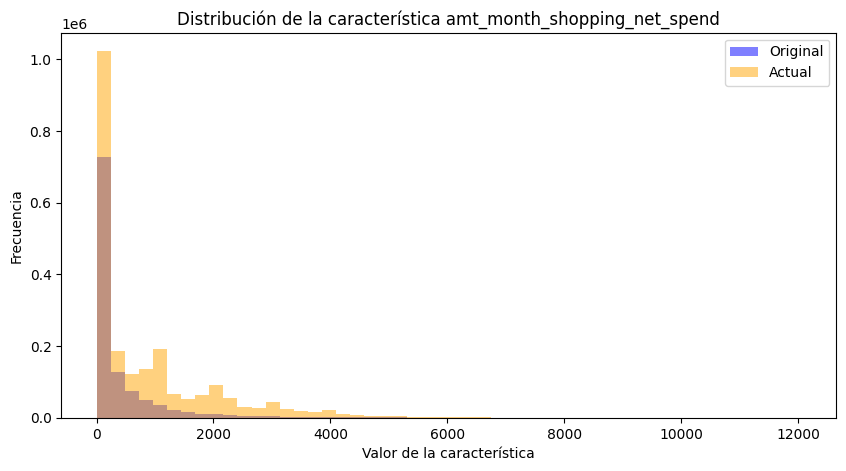

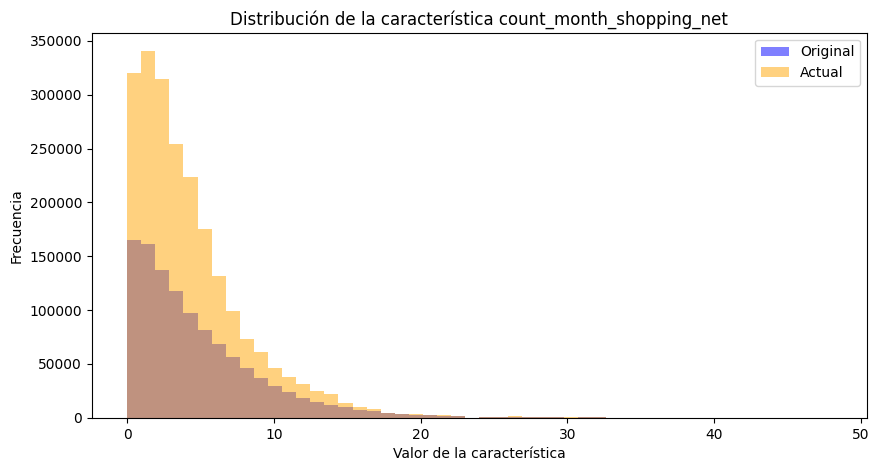

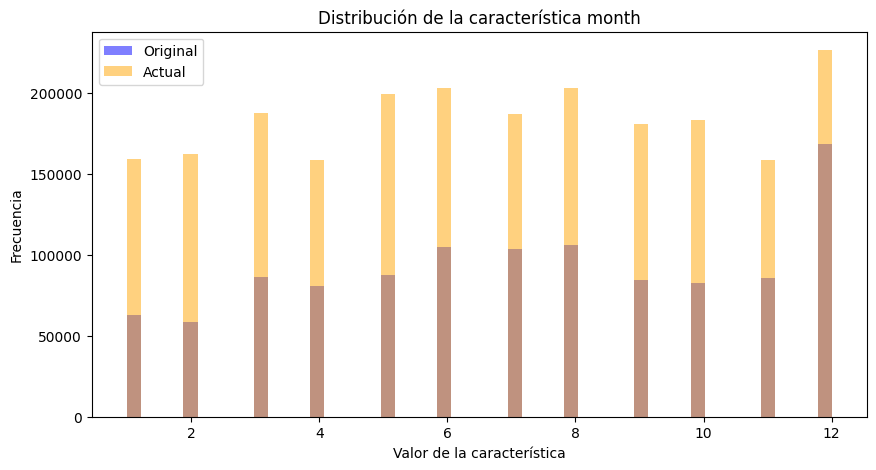

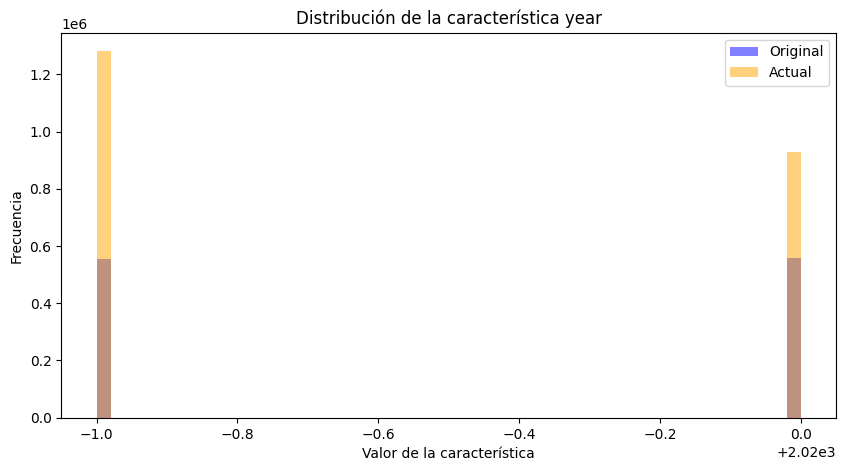

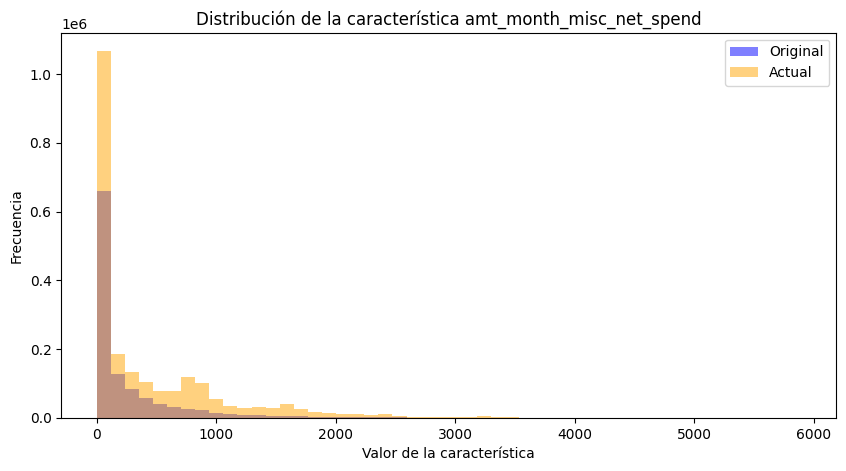

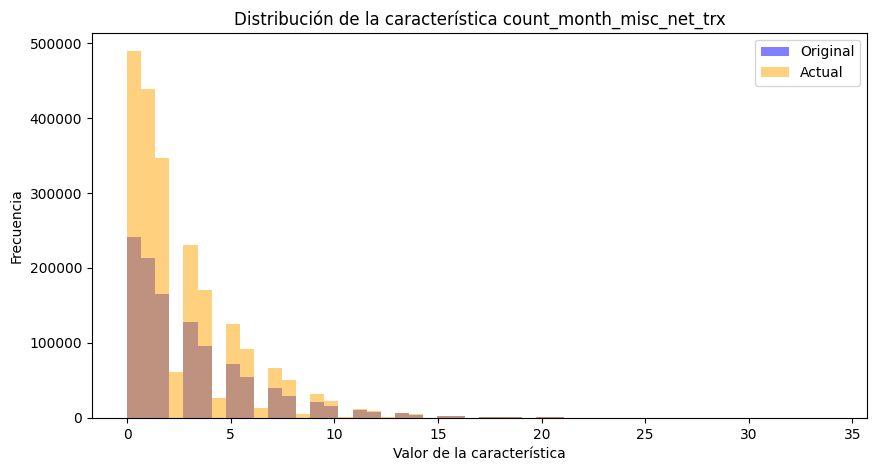

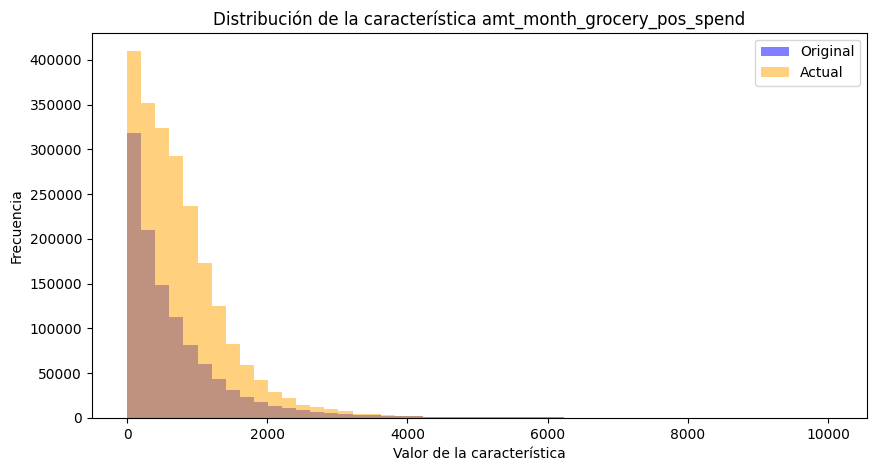

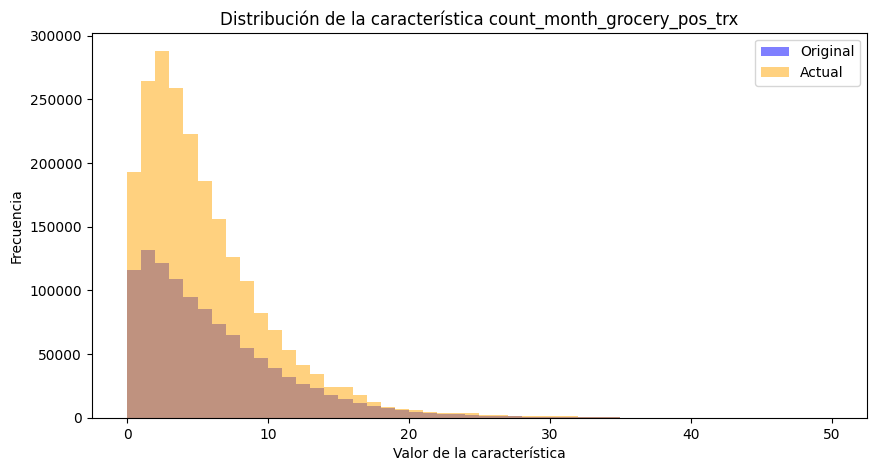

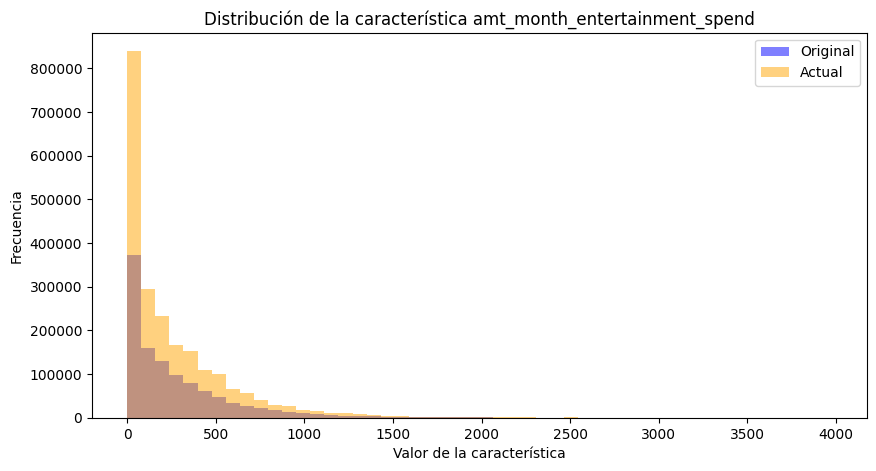

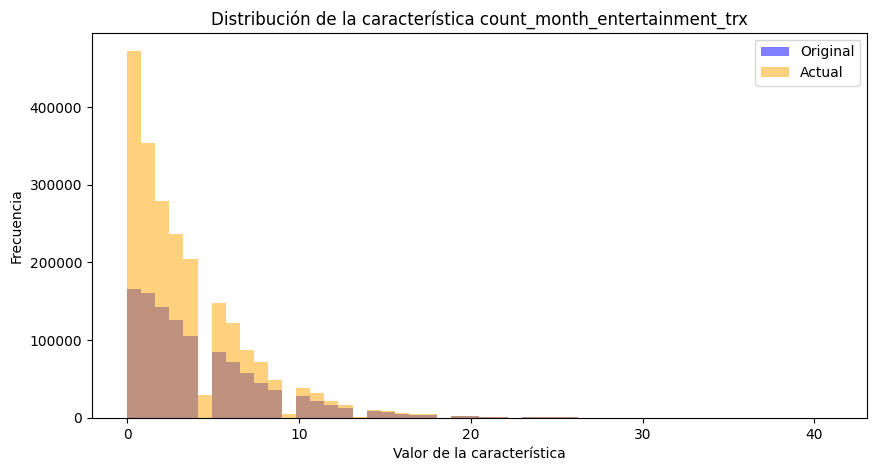

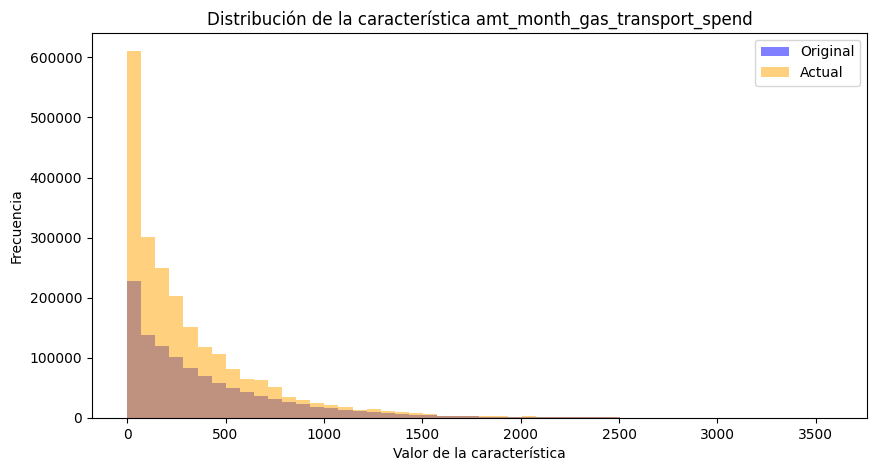

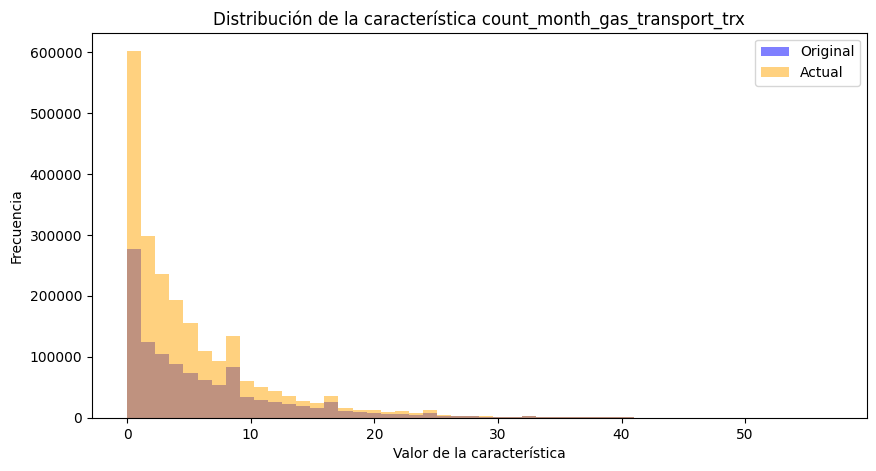

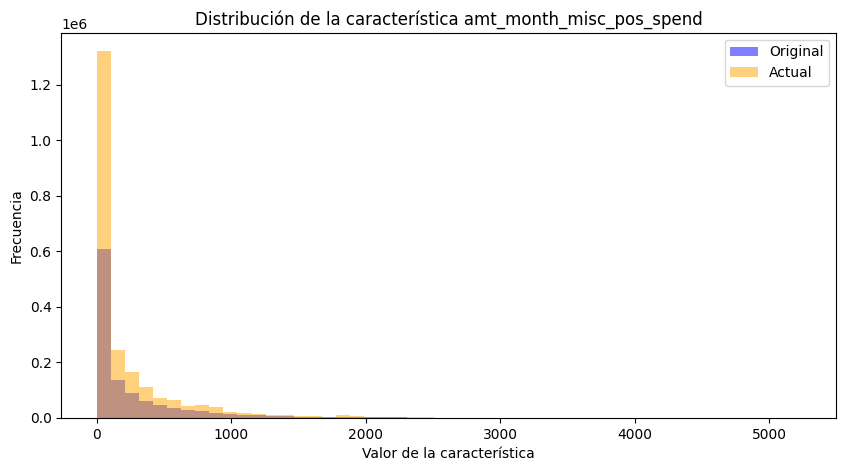

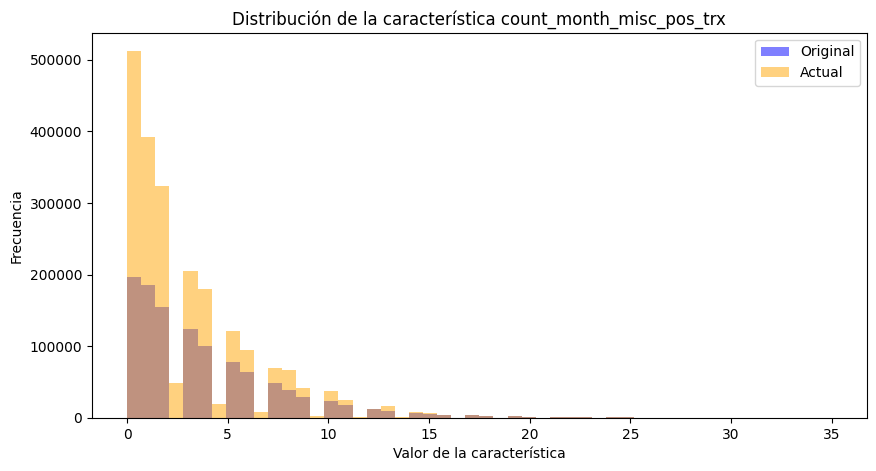

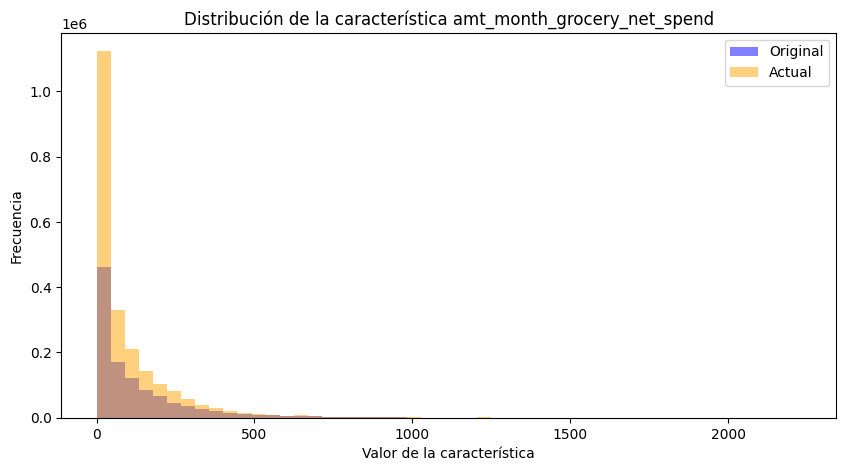

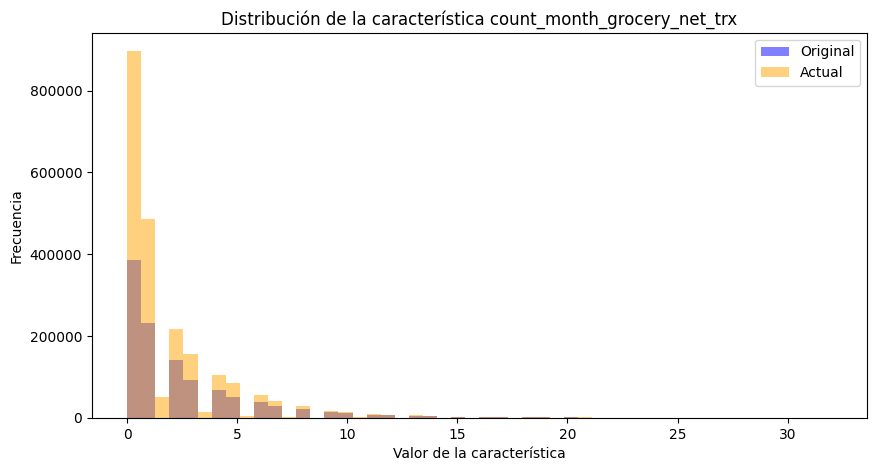

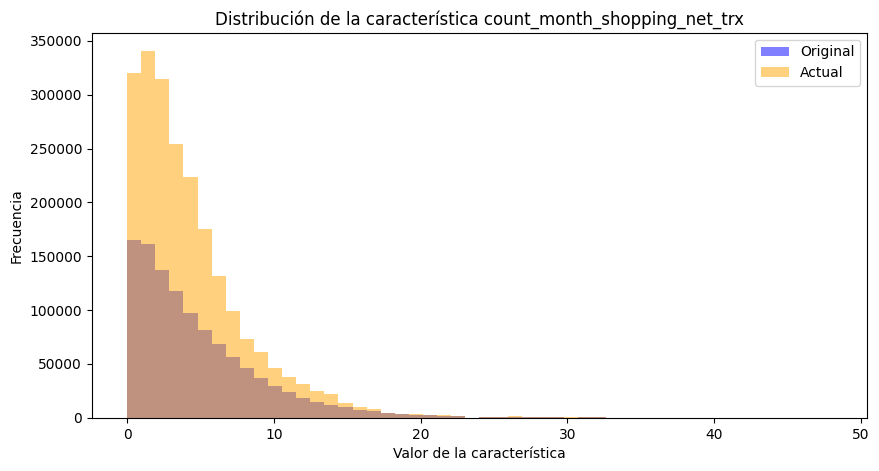

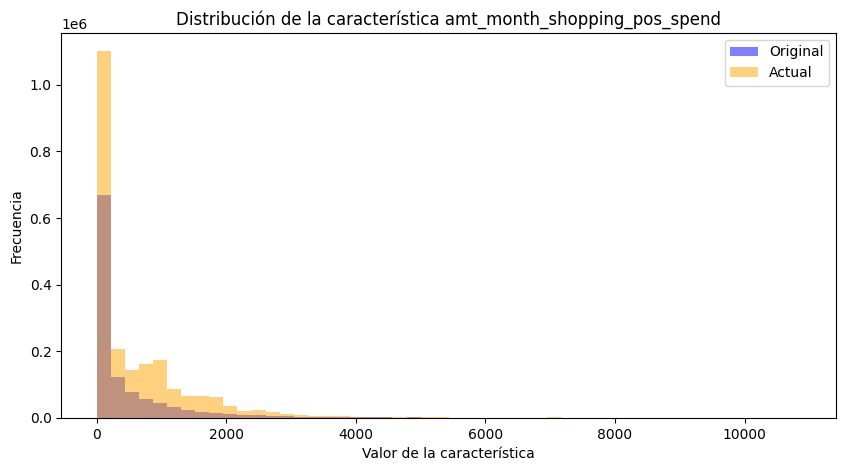

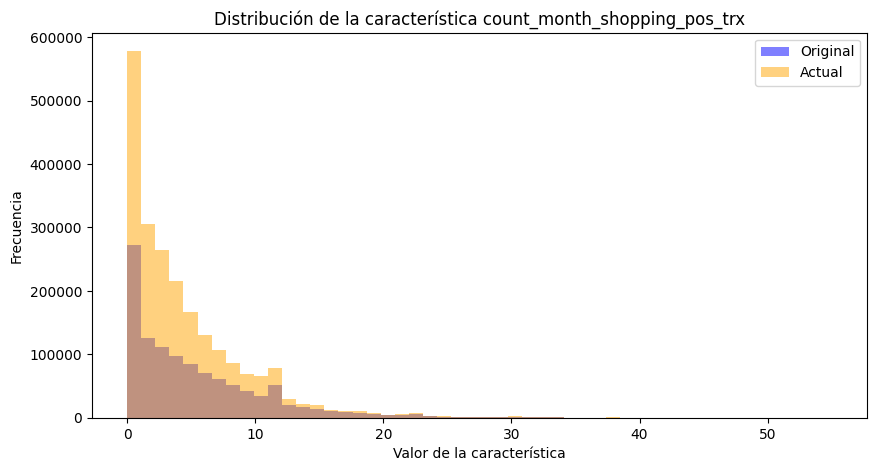

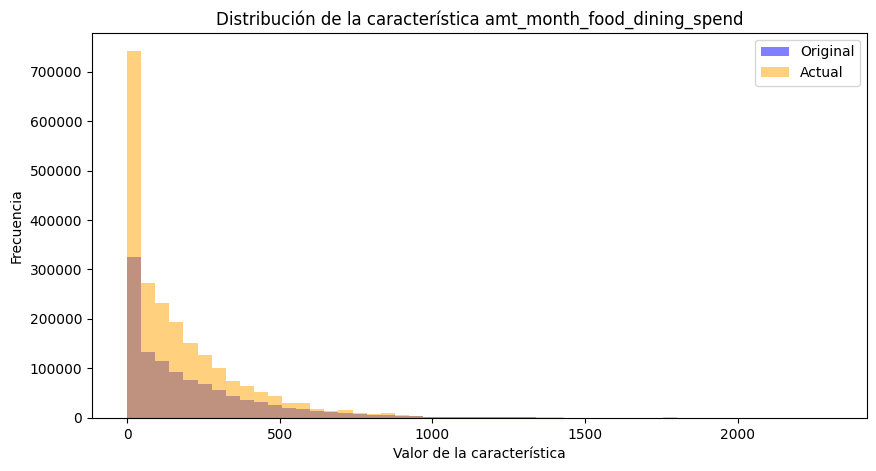

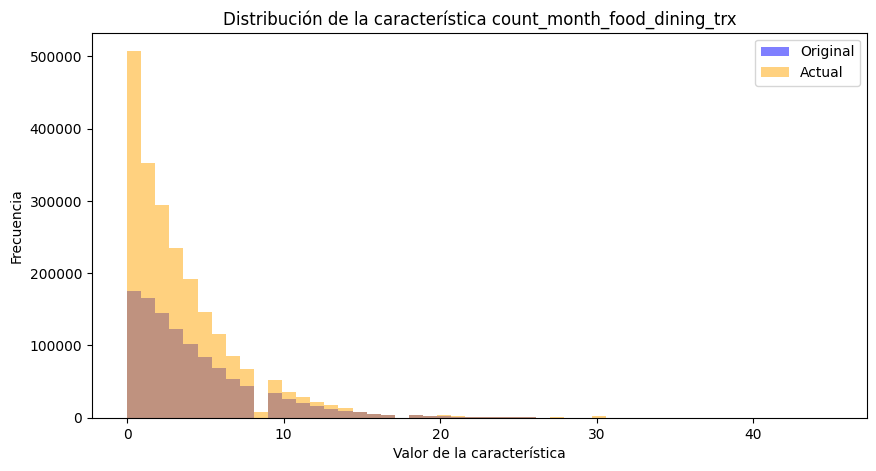

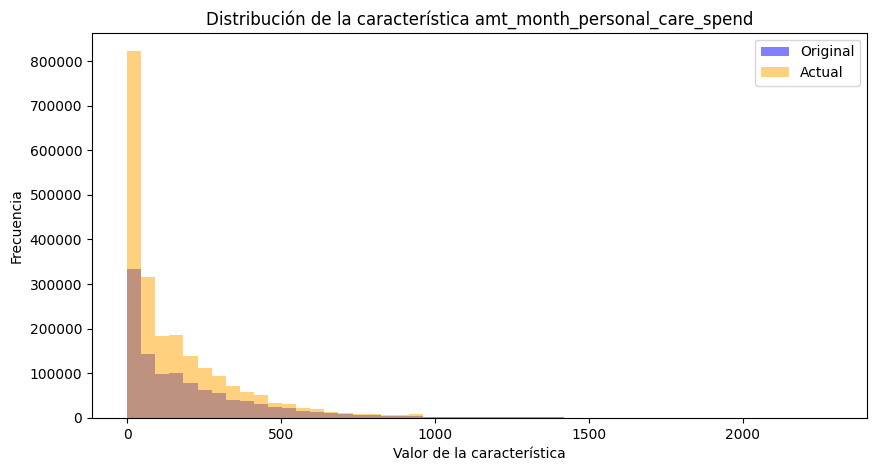

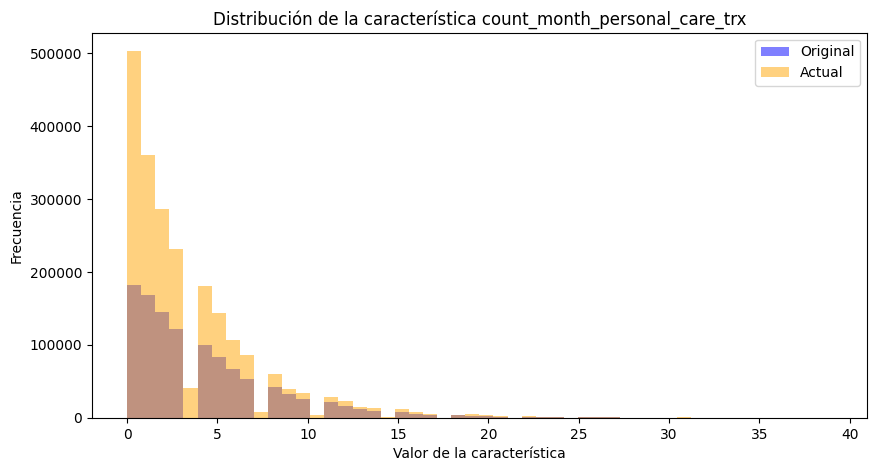

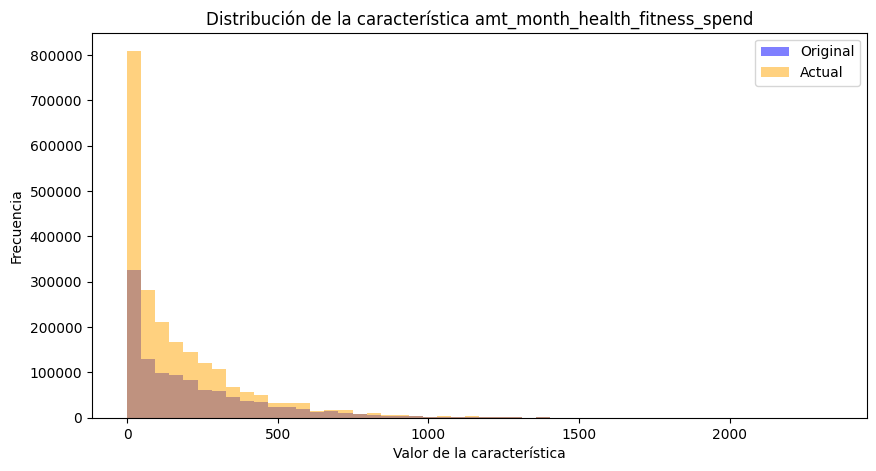

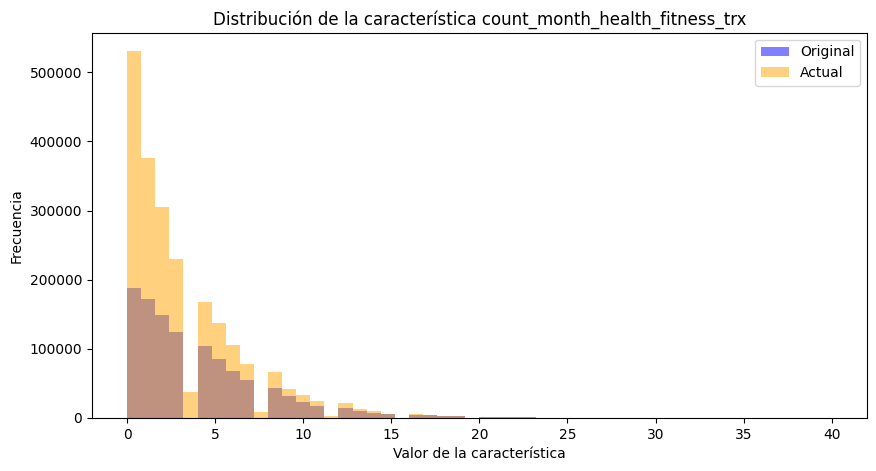

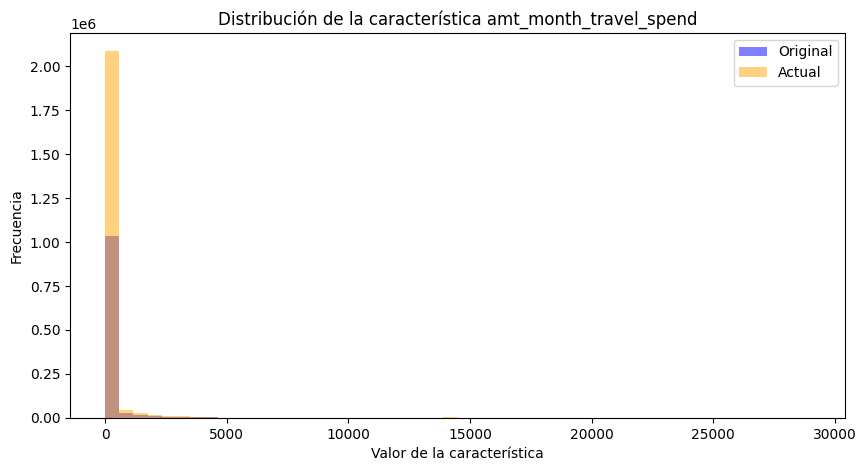

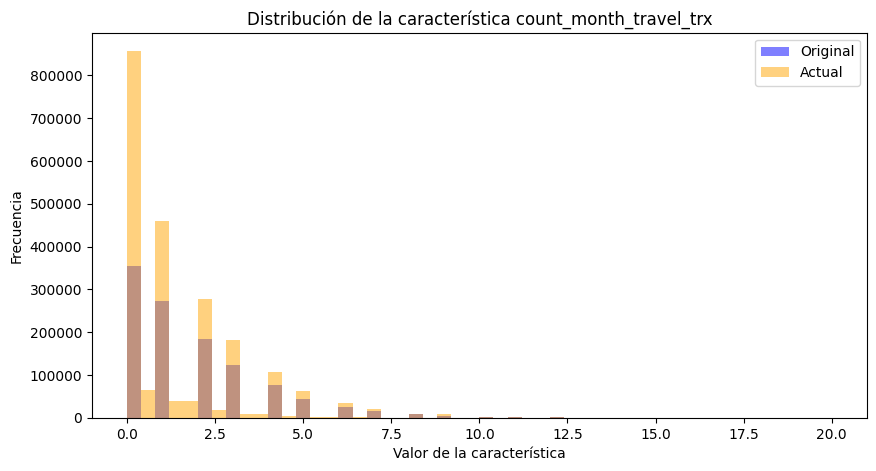

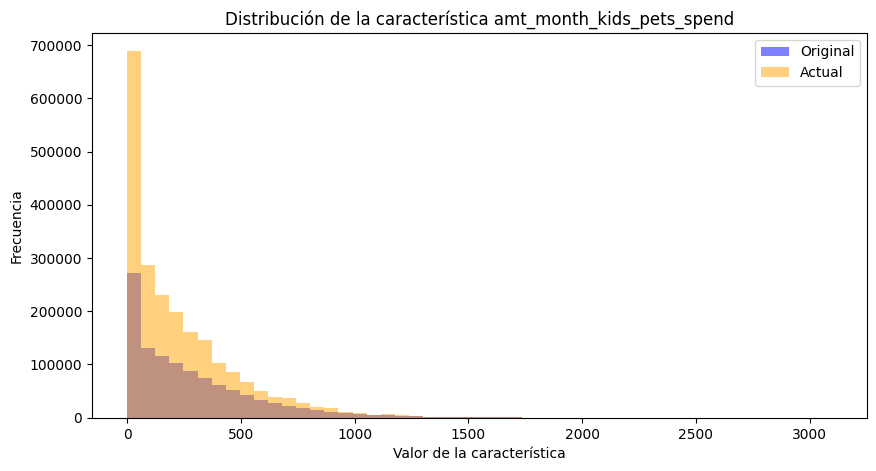

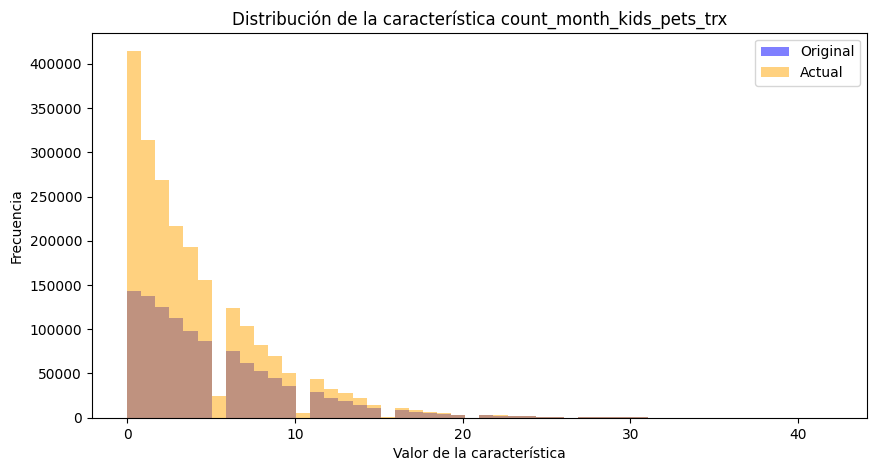

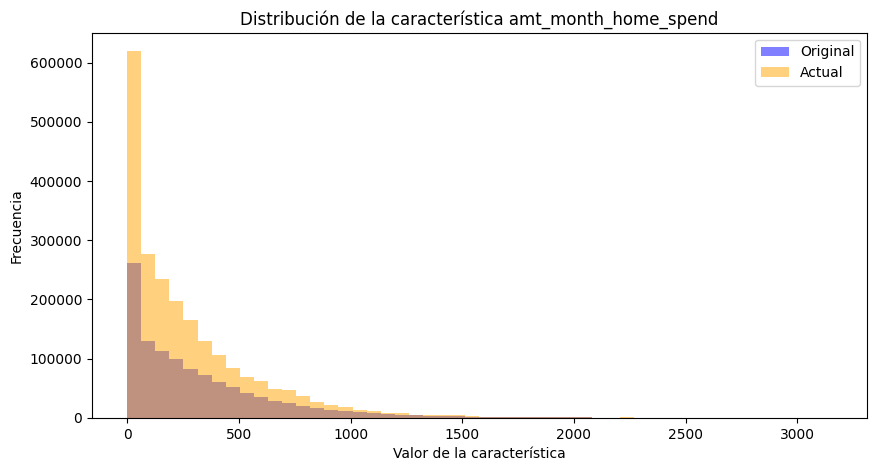

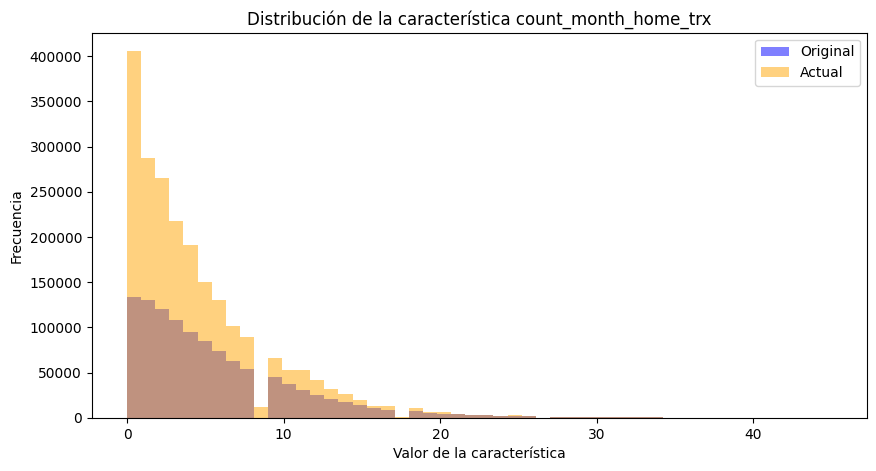

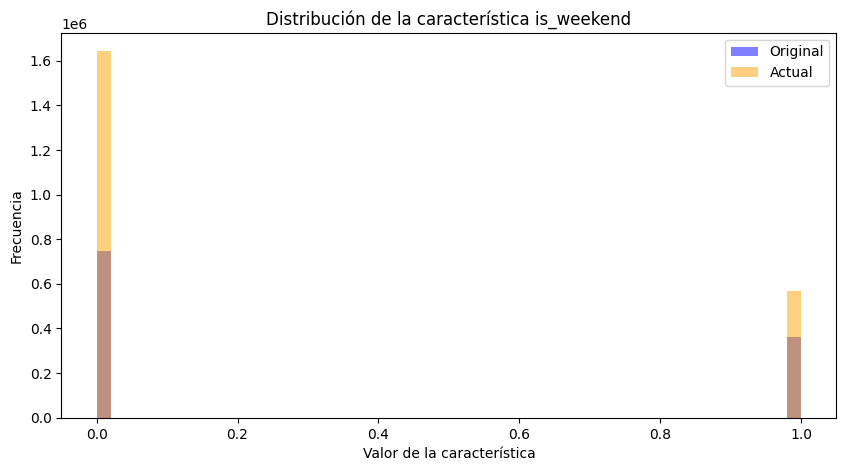

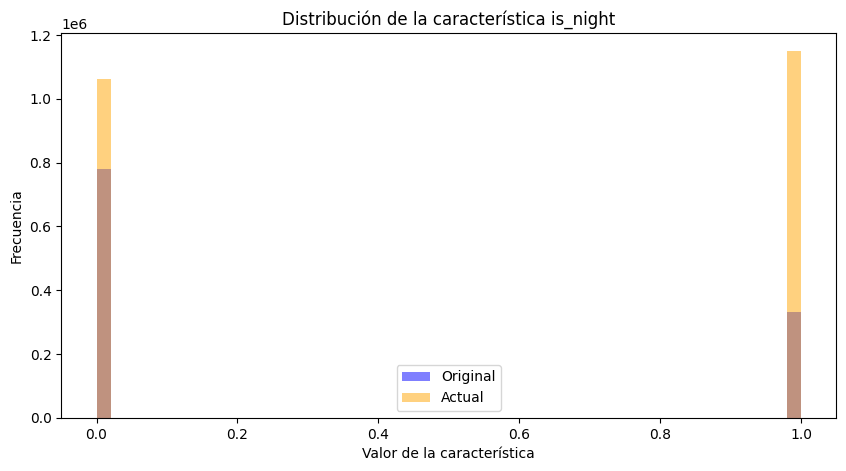

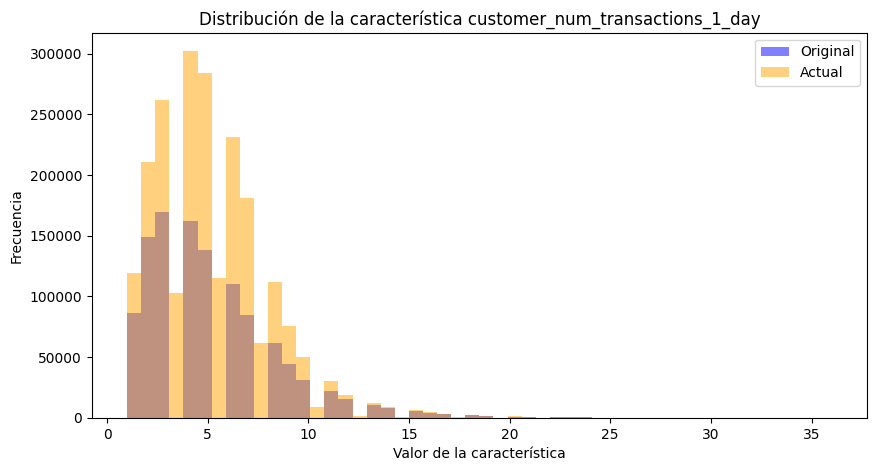

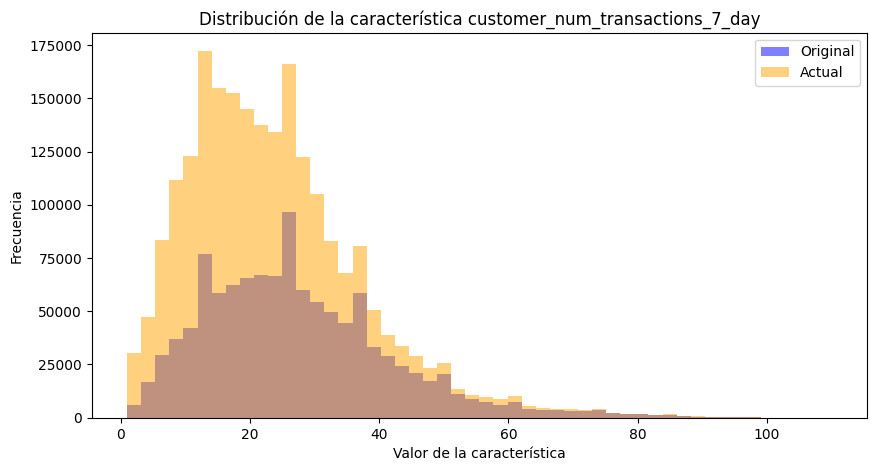

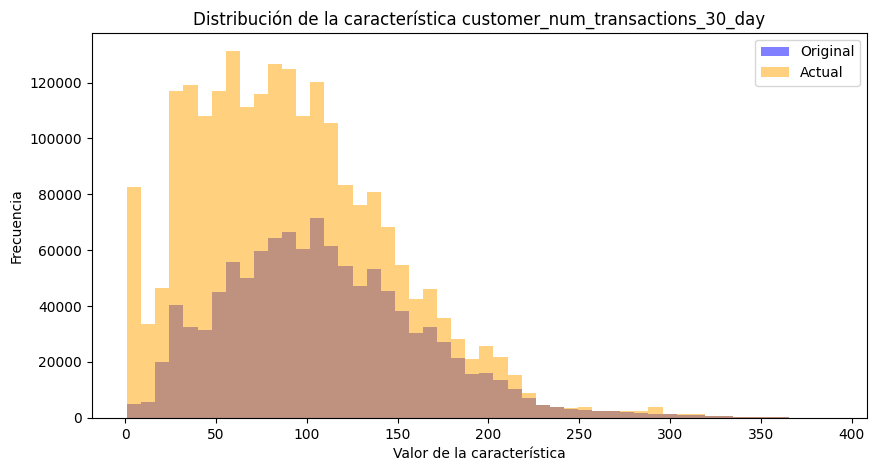

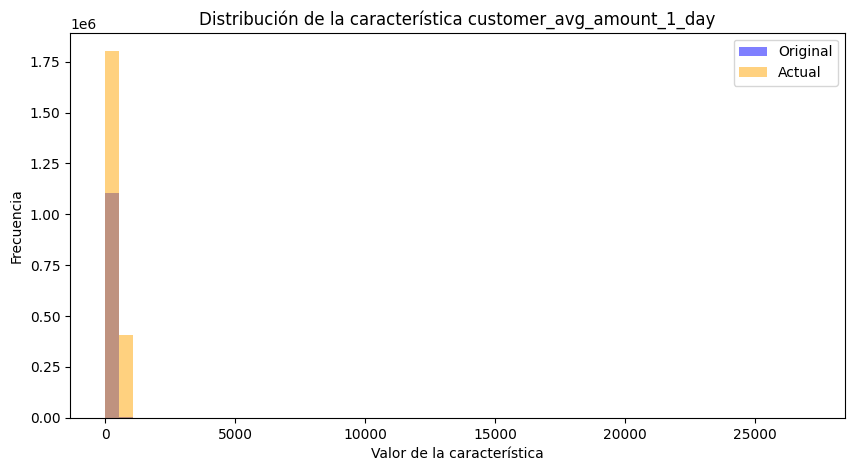

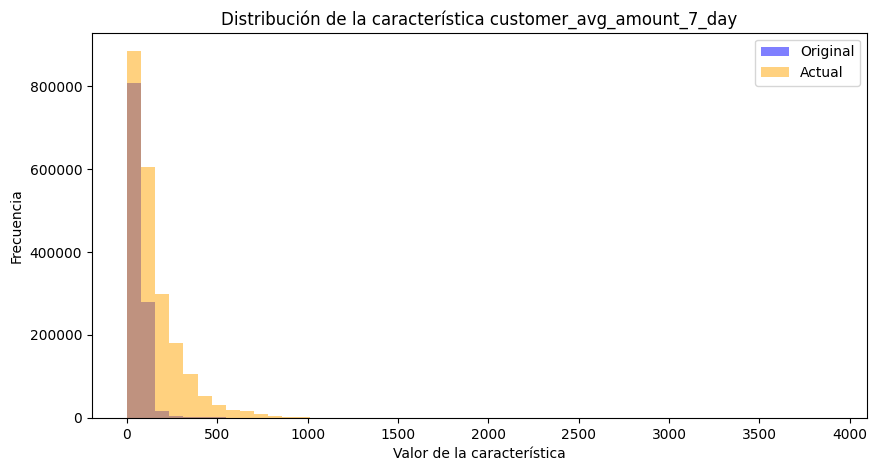

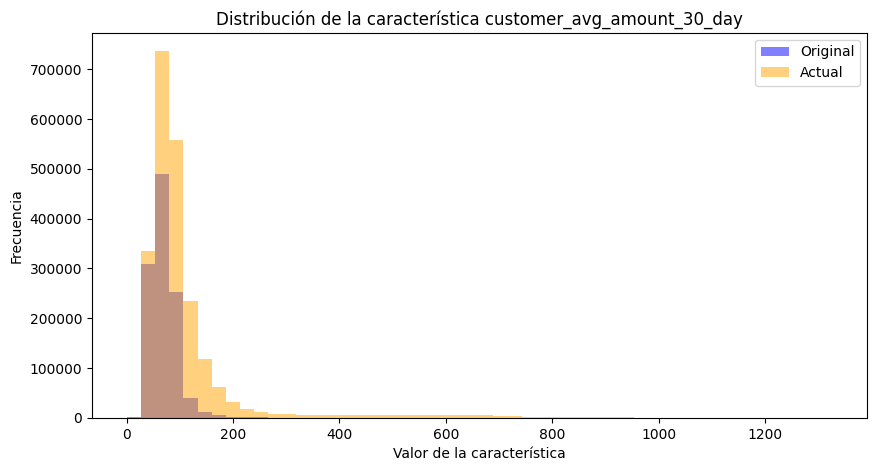

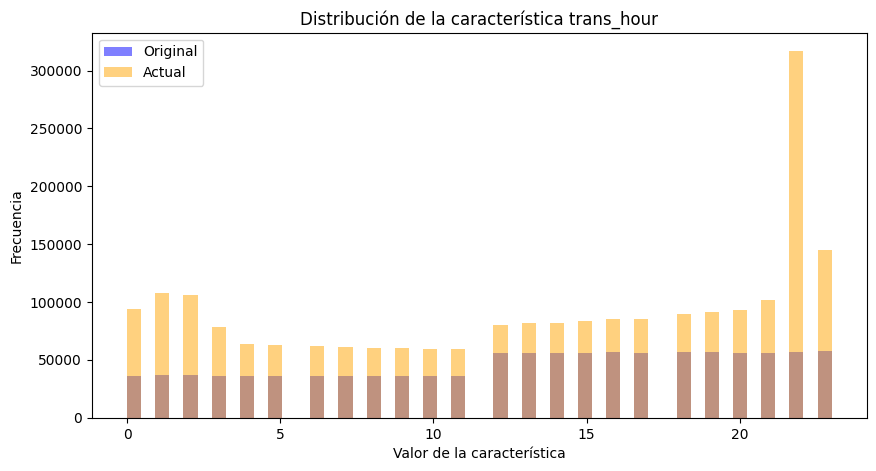

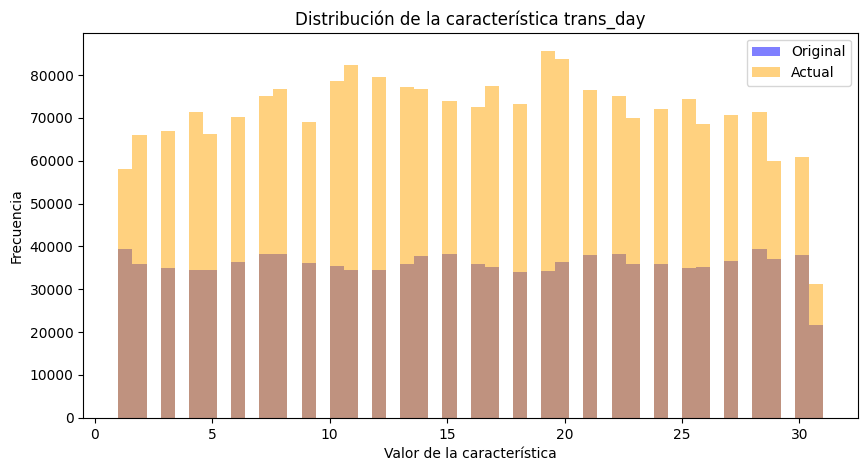

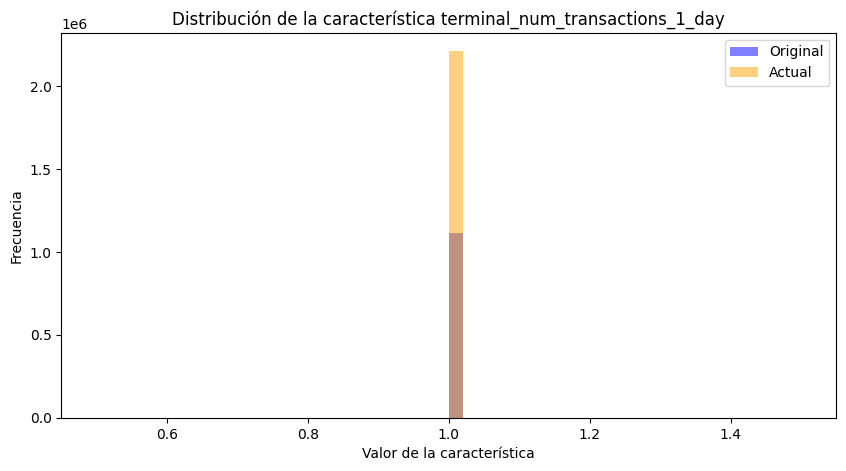

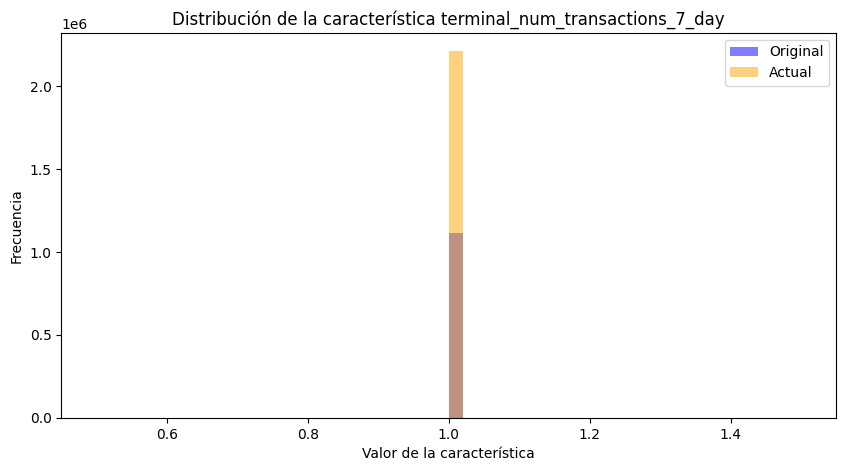

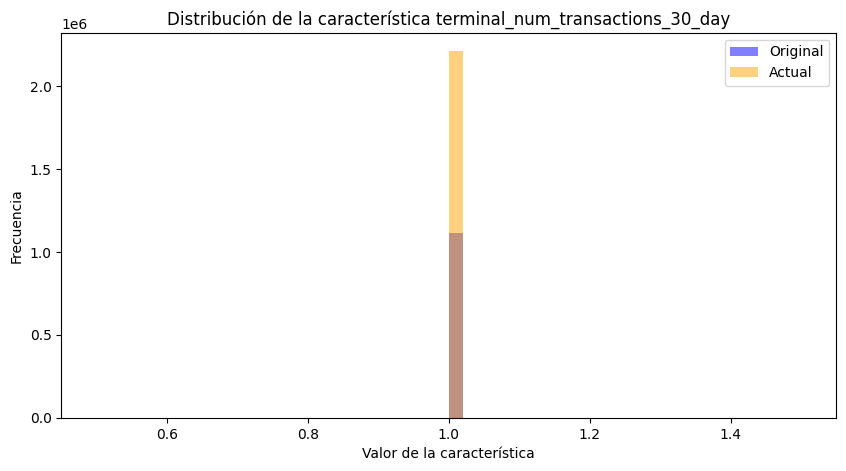

In [15]:
# Función para trazar histogramas de características
def plot_feature_distribution(feature_name):
    plt.figure(figsize=(10, 5))
    plt.hist(X_train[feature_name], bins=50, alpha=0.5, color='blue', label='Original')
    plt.hist(X_train_balanced[feature_name], bins=50, alpha=0.5, color='orange', label='Actual')
    plt.title('Distribución de la característica {}'.format(feature_name))
    plt.xlabel('Valor de la característica')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

# Seleccionar características numéricas para evaluar
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Trazar histogramas para cada característica numérica
for feature in numeric_features:
    plot_feature_distribution(feature)
